In [1]:
import sys
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from datetime import datetime
from itertools import combinations

PREDICCION_REAL = False
MAXIMIZAR_HIPERPARAMETROS = False
PARAMETROS = {"booster":"gbtree", "max_depth":3, "eta": 0.5, "objective": "binary:logistic", "nthread":2,"gamma" : 0}
RONDAS = 20

In [2]:
#APERTURA DE ARCHIVO DE ARCHIVOS
entrenamiento_temp = pd.read_csv("../Train_TP2_Datos_2020-2C.csv")
entrenamiento_temp = entrenamiento_temp[( entrenamiento_temp['Stage'] == 'Closed Won') | ( entrenamiento_temp['Stage'] == 'Closed Lost')]
entrenamiento_temp = entrenamiento_temp.loc[(entrenamiento_temp["ASP_Currency"] == entrenamiento_temp["Total_Taxable_Amount_Currency"])]
#entrenamiento = entrenamiento.loc[entrenamiento["Total_Taxable_Amount"] > 0]

test = pd.read_csv("../Test_TP2_Datos_2020-2C.csv")

In [3]:
#FORMATO FECHAS

#Respalda fecha, usada para separa entrenamiento y test
entrenamiento_temp['Fecha'] = pd.to_datetime(entrenamiento_temp['Opportunity_Created_Date'])
columnas_fecha = ['Month','Last_Modified_Date','Account_Created_Date','Opportunity_Created_Date','Quote_Expiry_Date','Planned_Delivery_Start_Date','Planned_Delivery_End_Date']

def formato_fechas(x):
    for columna in columnas_fecha:
        x[columna] = pd.to_datetime(x[columna])
        
formato_fechas(entrenamiento_temp)
if(PREDICCION_REAL): 
    formato_fechas(test)

In [4]:
#DIVISION ENTRE SET DE ENTRENAMIENTO Y SET DE TEST

if(PREDICCION_REAL):
    entrenamiento = entrenamiento_temp
else:
    entrenamiento = entrenamiento_temp.loc[entrenamiento_temp['Fecha'].dt.year == 2015].copy()
    test          = entrenamiento_temp.loc[entrenamiento_temp['Fecha'].dt.year == 2016].copy()
    entrenamiento_label = (entrenamiento['Stage'] == 'Closed Won').astype(int)
    test_label          = (test['Stage'] == 'Closed Won').astype(int)

del entrenamiento_temp


In [5]:
#LIMPIEZA

def limpiar(x):
    x = x.drop(columns=['ASP_(converted)_Currency','Quote_Type','Brand','Product_Type','Size','Product_Category_B','Price','Currency','Last_Activity','Actual_Delivery_Date','Prod_Category_A'])
    x = x.drop(columns=['ID','Opportunity_Name','Sales_Contract_No'])
    return x

entrenamiento = limpiar(entrenamiento)
test = limpiar(test)

In [6]:
#NUEVOS FEATURES

In [7]:
#Agrego feature: Duracion de la oportunidad
entrenamiento['Opportunity_Duration'] = (entrenamiento['Last_Modified_Date'] - entrenamiento['Opportunity_Created_Date']) / np.timedelta64(1, 'D')
test['Opportunity_Duration'] = (test['Last_Modified_Date'] - test['Opportunity_Created_Date']) / np.timedelta64(1, 'D')
#Agrego feature: Total_Amount_USD
entrenamiento["Total_Amount_USD"] = entrenamiento["Total_Amount"] * entrenamiento["ASP_(converted)"] / entrenamiento["ASP"]
test["Total_Amount_USD"] = test["Total_Amount"] * test["ASP_(converted)"] / test["ASP"]
#Agrego feature: Total_Taxable_Amount_USD
entrenamiento["Total_Taxable_Amount_USD"] = entrenamiento["Total_Taxable_Amount"] * entrenamiento["ASP_(converted)"] / entrenamiento["ASP"]
test["Total_Taxable_Amount_USD"] = test["Total_Taxable_Amount"] * test["ASP_(converted)"] / test["ASP"]
#Agrego feature: Total_Amount_sobre_Total_Taxable_Amount
entrenamiento["Total_Amount_sobre_Total_Taxable_Amount"] = entrenamiento["Total_Amount_USD"] / entrenamiento["Total_Taxable_Amount_USD"]
test["Total_Amount_sobre_Total_Taxable_Amount"] = test["Total_Amount_USD"] / test["Total_Taxable_Amount_USD"]

"""
#Se debe solo usar los del train, no los del test, CAMBIAR
entrenamiento["Billing_Country_Vida_Util"] = entrenamiento.groupby("Billing_Country")["Opportunity_Duration"].transform("mean")
entrenamiento["Account_Type_Vida_Util"] = entrenamiento.groupby("Account_Type")["Opportunity_Duration"].transform("mean")
entrenamiento["Region_ASP"] = entrenamiento.groupby("Region")["ASP"].transform("mean")
entrenamiento["Billing_Country_ASP"] = entrenamiento.groupby("Billing_Country")["ASP"].transform("mean")
entrenamiento["Billing_Country_Total_Amount"] = entrenamiento.groupby("Billing_Country")["Total_Amount_USD"].transform("mean")
entrenamiento["Billing_Country_Buro"] = entrenamiento.groupby("Billing_Country")["Bureaucratic_Code_0_Approved"].transform("mean")
entrenamiento["Product_Family_Vida_Util"] = entrenamiento.groupby("Product_Family")["Opportunity_Duration"].transform("mean")
entrenamiento["Product_Family_Total_Amount"] = entrenamiento.groupby("Product_Family")["Total_Amount"].transform("mean")
entrenamiento["Product_Family_Buro"] = entrenamiento.groupby("Product_Family")["Bureaucratic_Code_0_Approved"].transform("mean")
"""

'\n#Se debe solo usar los del train, no los del test, CAMBIAR\nentrenamiento["Billing_Country_Vida_Util"] = entrenamiento.groupby("Billing_Country")["Opportunity_Duration"].transform("mean")\nentrenamiento["Account_Type_Vida_Util"] = entrenamiento.groupby("Account_Type")["Opportunity_Duration"].transform("mean")\nentrenamiento["Region_ASP"] = entrenamiento.groupby("Region")["ASP"].transform("mean")\nentrenamiento["Billing_Country_ASP"] = entrenamiento.groupby("Billing_Country")["ASP"].transform("mean")\nentrenamiento["Billing_Country_Total_Amount"] = entrenamiento.groupby("Billing_Country")["Total_Amount_USD"].transform("mean")\nentrenamiento["Billing_Country_Buro"] = entrenamiento.groupby("Billing_Country")["Bureaucratic_Code_0_Approved"].transform("mean")\nentrenamiento["Product_Family_Vida_Util"] = entrenamiento.groupby("Product_Family")["Opportunity_Duration"].transform("mean")\nentrenamiento["Product_Family_Total_Amount"] = entrenamiento.groupby("Product_Family")["Total_Amount"].t

In [8]:
#FEATURE - Duracion por familia
df_zona = entrenamiento[['Stage','Region','Territory','Product_Family','Planned_Delivery_Start_Date']]
df_zona = df_zona[df_zona['Stage'] == 'Closed Won']
df_familia = df_zona.groupby(['Product_Family'])['Planned_Delivery_Start_Date'].agg(['max','min']).reset_index()
df_familia['Duracion'] = (df_familia['max'] - df_familia['min']).dt.days
df_familia.columns = ['Product_Family','Planed_Delivery_Fecha_Max','min','Duracion_Familia']
entrenamiento = entrenamiento.merge(df_familia[['Product_Family','Duracion_Familia','Planed_Delivery_Fecha_Max']],on='Product_Family',how='left')
entrenamiento['Vida_Util_Ventaja'] =  (entrenamiento['Planned_Delivery_Start_Date'] - entrenamiento['Planed_Delivery_Fecha_Max']).dt.days - entrenamiento['Duracion_Familia']
entrenamiento = entrenamiento.drop('Planed_Delivery_Fecha_Max',1)
test = test.merge(entrenamiento[['Product_Family','Duracion_Familia','Vida_Util_Ventaja']].drop_duplicates(subset=['Product_Family']),left_on='Product_Family',right_on='Product_Family',how='left')

#FEATURE - Duracion por region
df_zona = entrenamiento[['Stage','Region','Territory','Product_Family','Planned_Delivery_Start_Date']]
df_zona = df_zona[df_zona['Stage'] == 'Closed Won']
df_region = df_zona.groupby(['Region'])['Planned_Delivery_Start_Date'].agg(['max','min']).reset_index()
df_region['Duracion'] = (df_region['max'] - df_region['min']).dt.days
df_region.columns = ['Region','Region_Planed_Delivery_Fecha_Max','Region_min','Duracion_Region']
entrenamiento = entrenamiento.merge(df_region[['Region','Duracion_Region','Region_Planed_Delivery_Fecha_Max']],on='Region',how='left')
entrenamiento['Region_Vida_Util_Ventaja'] =  (entrenamiento['Planned_Delivery_Start_Date'] - entrenamiento['Region_Planed_Delivery_Fecha_Max']).dt.days - entrenamiento['Duracion_Region']
entrenamiento = entrenamiento.drop('Region_Planed_Delivery_Fecha_Max',1)
test = test.merge(entrenamiento[['Region','Duracion_Region','Region_Vida_Util_Ventaja']].drop_duplicates(subset=['Region']),left_on='Region',right_on='Region',how='left')

#FEATURE - Duracion por territorio
df_zona = entrenamiento[['Stage','Region','Territory','Product_Family','Planned_Delivery_Start_Date']]
df_zona = df_zona[df_zona['Stage'] == 'Closed Won']
df_territorio = df_zona.groupby(['Territory'])['Planned_Delivery_Start_Date'].agg(['max','min']).reset_index()
df_territorio['Duracion'] = (df_territorio['max'] - df_territorio['min']).dt.days
df_territorio.columns = ['Territory','Territory_Planed_Delivery_Fecha_Max','Territory_min','Duracion_Territory']
entrenamiento = entrenamiento.merge(df_territorio[['Territory','Duracion_Territory','Territory_Planed_Delivery_Fecha_Max']],on='Territory',how='left')
entrenamiento['Territory_Vida_Util_Ventaja'] =  (entrenamiento['Planned_Delivery_Start_Date'] - entrenamiento['Territory_Planed_Delivery_Fecha_Max']).dt.days - entrenamiento['Duracion_Territory']
entrenamiento = entrenamiento.drop('Territory_Planed_Delivery_Fecha_Max',1)
test = test.merge(entrenamiento[['Territory','Duracion_Territory','Territory_Vida_Util_Ventaja']].drop_duplicates(subset=['Territory']),left_on='Territory',right_on='Territory',how='left')

In [9]:
#FECHAS A DIAS
def fecha_a_dias(x):
    for columna in columnas_fecha:
        x[columna] = x[columna].apply(lambda x : (x - pd.to_datetime('01/01/2000', format='%m/%d/%Y')).days)

fecha_a_dias(entrenamiento)
fecha_a_dias(test)

In [10]:
#CATEGORICAS A NUMERICAS - PROMEDIO
"""Se debe pasar train y test ordenados """
def expansion_mean_encoding(columnas_categoricas,train,test,label):
    #Dividimos el dataset de entrenamiento en features y labels
    #Armo un df extra que me ayudara para codificar las categoricas.
    #x_y_train = filtrado.iloc[:-test_rows]
    #x_train = x_y_train.drop('Stage', axis=1)
    #y_train = x_y_train['Stage'].to_frame()
    #x_test = filtrado.iloc[-test_rows:].drop('Stage', axis=1)
    #y_test = filtrado.iloc[-test_rows:]['Stage'].to_frame()

    #En el set de train.
    #columnas_categoricas = x_train.select_dtypes(include='category').columns

    codificaciones = dict()

    for col in columnas_categoricas:
        last_one = train.groupby(col).tail(1)
        for (idx, reg) in zip(last_one[col].index, last_one[col].values):
            codificaciones[reg] = (col, idx)
        cumulative_sum = train.groupby(col)[label].cumsum() - train[label]
        cumulative_count = train.groupby(col).cumcount()
        train[col] = cumulative_sum/cumulative_count

    #Llenamos los NaN generados por cumsum con ceros.
    train.fillna(0,inplace = True)

    #Guardamos la codificacion de cada categoria segun su nombre.
    for k, v in codificaciones.items():
        col = v[0]
        idx = v[1]
        codificaciones[k] = train.loc[idx, col]
    
    # Utilizo las ultimas codificaciones de cada categoria del train set para codificar el test set.
    # Para eso utilizo el diccionario de codificaciones.

    #columnas_categoricas = x_test.select_dtypes(include='category').columns

    for col in columnas_categoricas:
        test[col] = test[col].astype(object)
        for (idx, reg) in zip(test[col].index, test[col]):
            if (reg in codificaciones):
                test.loc[idx, col] = codificaciones[reg]
            else:
                #Codifico como cero, se puede mejorar
                test.loc[idx, col] = 0
        test[col] = test[col].astype(float)
        
columnas_categoricas = list(entrenamiento.select_dtypes(include=['object']).columns)
if 'Stage' in columnas_categoricas : columnas_categoricas.remove('Stage')
entrenamiento["label"] = (entrenamiento['Stage'] == 'Closed Won').astype(int)
entrenamiento.sort_values("Fecha")
expansion_mean_encoding(columnas_categoricas,entrenamiento,test,"label")
entrenamiento = entrenamiento.drop(columns='label')

In [11]:
#CATEGORICAS A NUMERICAS  - ORDINAL
def categoricas_a_numericas(x):
    ohe = skl.preprocessing.OrdinalEncoder()
    columnas_object = list(x.select_dtypes(include=['object']).columns)
    if 'Stage' in columnas_object : columnas_object.remove('Stage')
    for columna in columnas_object:
        copia = x[[columna]].copy().dropna()
        df_temp = pd.DataFrame(ohe.fit_transform(copia)).astype('int32')
        df_temp.columns = [columna]
        x[columna] = df_temp[columna]

categoricas_a_numericas(entrenamiento)
categoricas_a_numericas(test)

In [12]:
#Filtrado de columnas - No remover Stage o Fecha
#entrenamiento = entrenamiento[['Total_Amount_Currency']]

In [13]:
if(PREDICCION_REAL):
    objetivo = (entrenamiento['Stage'] == 'Closed Won').astype(int)
    entrenamiento = entrenamiento.drop(columns=['Stage','Fecha'])
    
    d_entrenamiento = xgb.DMatrix(entrenamiento.values, objetivo.values)
    d_prueba = xgb.DMatrix(test.values)
    
    bst = xgb.train(PARAMETROS, d_entrenamiento, RONDAS)
    preds = bst.predict(d_prueba)

    resultados = test[['Opportunity_ID']].copy()
    resultados['Target'] = pd.Series(preds)
    resultados = resultados.groupby('Opportunity_ID').mean()
    resultados = resultados.reset_index()
    resultados['Target'] = resultados['Target'].apply(lambda x: int(x >= 0.5))
    
    resultados.to_csv("prediccion.csv", index=False)
    resultados['Target'].value_counts()

In [14]:
if(PREDICCION_REAL): sys.exit()

In [15]:
set_entrenamiento = xgb.DMatrix(entrenamiento.drop(columns=['Stage','Fecha']),label = entrenamiento_label)
set_test  = xgb.DMatrix(test .drop(columns=['Stage','Fecha']),label = test_label)
evaluacion = [(set_test, 'eval'), (set_entrenamiento, 'train')]

[23:52:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.72137	train-logloss:0.42997
[1]	eval-logloss:0.76777	train-logloss:0.30754
[2]	eval-logloss:0.81938	train-logloss:0.23494
[3]	eval-logloss:0.86853	train-logloss:0.18731
[4]	eval-logloss:0.90146	train-logloss:0.15309
[5]	eval-logloss:0.87295	train-logloss:0.12982
[6]	eval-logloss:0.81573	train-logloss:0.11002
[7]	eval-logloss:0.75588	train-logloss:0.09530
[8]	eval-logloss:0.69537	train-logloss:0.08243
[9]	eval-logloss:0.67366	train-logloss:0.07313
[10]	eval-logloss:0.63250	train-logloss:0.06368
[11]	eval-logloss:0.67089	train-logloss:0.05790
[12]	eval-logloss:0.68217	train-logloss:0.04984
[13]	eval-logloss:0.67468	train-logloss:0.04610
[14]	eval-logloss:0.65798	tr

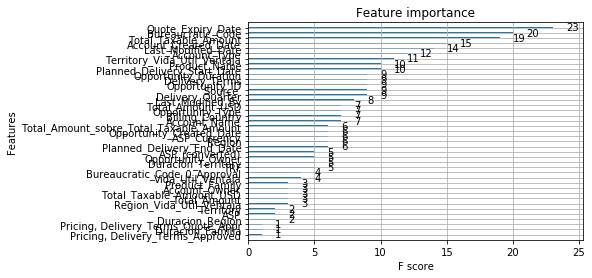

In [21]:
modelo = xgb.train(PARAMETROS, set_entrenamiento, RONDAS, evaluacion)

xgb.plot_importance(modelo)
plt.show()

In [22]:
prediccion = modelo.predict(set_test)

prediccion = [1 if i > .5 else 0 for i in prediccion]

def metricas(objetivo, prediccion):
    matriz_conf = confusion_matrix(objetivo, prediccion)
    score = accuracy_score(objetivo, prediccion)
    reporte = classification_report(objetivo, prediccion)
    metricas = [matriz_conf, score, reporte]
    return(metricas)

metrics = metricas(test_label, prediccion)
print("Prediccion Test")
[print(i) for i in metrics]
print(skl.metrics.log_loss(test_label,prediccion))

prediccion = modelo.predict(set_entrenamiento)
prediccion = [1 if i > .5 else 0 for i in prediccion]
metricas = metricas(entrenamiento_label, prediccion)
print("Prediccion Train")
[print(i) for i in metricas]

Prediccion Test
[[1217 1034]
 [ 187 1908]]
0.7190520018407731
              precision    recall  f1-score   support

           0       0.87      0.54      0.67      2251
           1       0.65      0.91      0.76      2095

    accuracy                           0.72      4346
   macro avg       0.76      0.73      0.71      4346
weighted avg       0.76      0.72      0.71      4346

9.703790327181034
Prediccion Train
[[732   0]
 [  0 275]]
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       732
           1       1.00      1.00      1.00       275

    accuracy                           1.00      1007
   macro avg       1.00      1.00      1.00      1007
weighted avg       1.00      1.00      1.00      1007



[None, None, None]

In [ ]:
if(not MAXIMIZAR_HIPERPARAMETROS): sys.exit()

In [20]:
min_log_loss = 1000
d = 1000
e = 1000
r = 1000
for depth in range(2,14):
    for eta in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
        for rondas in [10,20,30,40]:
            parametros = {"booster":"gbtree", "max_depth":depth, "eta": eta, "objective": "binary:logistic", "nthread":2}
            modelo = xgb.train(parametros, set_entrenamiento, rondas, evaluacion)
            prediccion = modelo.predict(set_test)
            prediccion = [1 if i > .5 else 0 for i in prediccion]
            log_loss = skl.metrics.log_loss(test_label,prediccion)
            if (log_loss < min_log_loss):
                min_log_loss = log_loss
                d = depth
                e = eta
                r = rondas


print("log: ",min_log_loss)                
print("depth: ",d)      
print("eta: ",e)      
print("rondas: ",r)

[23:49:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.68995	train-logloss:0.62588
[1]	eval-logloss:0.69072	train-logloss:0.57077
[2]	eval-logloss:0.69446	train-logloss:0.52496
[3]	eval-logloss:0.70043	train-logloss:0.48641
[4]	eval-logloss:0.70801	train-logloss:0.45371
[5]	eval-logloss:0.71694	train-logloss:0.42566
[6]	eval-logloss:0.72675	train-logloss:0.40103
[7]	eval-logloss:0.73799	train-logloss:0.37956
[8]	eval-logloss:0.74859	train-logloss:0.36050
[9]	eval-logloss:0.75974	train-logloss:0.34356
[23:49:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

[1]	eval-logloss:0.70178	train-logloss:0.48016
[2]	eval-logloss:0.71942	train-logloss:0.41968
[3]	eval-logloss:0.74204	train-logloss:0.37374
[4]	eval-logloss:0.76448	train-logloss:0.33852
[5]	eval-logloss:0.79118	train-logloss:0.31072
[6]	eval-logloss:0.74626	train-logloss:0.28743
[7]	eval-logloss:0.70082	train-logloss:0.26316
[8]	eval-logloss:0.66285	train-logloss:0.24728
[9]	eval-logloss:0.63479	train-logloss:0.23337
[10]	eval-logloss:0.61331	train-logloss:0.22145
[11]	eval-logloss:0.60933	train-logloss:0.20925
[12]	eval-logloss:0.58222	train-logloss:0.20028
[13]	eval-logloss:0.58544	train-logloss:0.19253
[14]	eval-logloss:0.55321	train-logloss:0.18588
[15]	eval-logloss:0.55519	train-logloss:0.17853
[16]	eval-logloss:0.53698	train-logloss:0.17268
[17]	eval-logloss:0.52247	train-logloss:0.16765
[18]	eval-logloss:0.51681	train-logloss:0.16293
[19]	eval-logloss:0.51300	train-logloss:0.15957
[20]	eval-logloss:0.49465	train-logloss:0.15579
[21]	eval-logloss:0.48661	train-logloss:0.15221
[

[11]	eval-logloss:0.55639	train-logloss:0.16586
[12]	eval-logloss:0.54835	train-logloss:0.15902
[13]	eval-logloss:0.52335	train-logloss:0.15207
[14]	eval-logloss:0.50057	train-logloss:0.14592
[15]	eval-logloss:0.49075	train-logloss:0.14170
[16]	eval-logloss:0.48729	train-logloss:0.13824
[17]	eval-logloss:0.47564	train-logloss:0.13378
[18]	eval-logloss:0.46257	train-logloss:0.12964
[19]	eval-logloss:0.45950	train-logloss:0.12637
[20]	eval-logloss:0.44748	train-logloss:0.12202
[21]	eval-logloss:0.44939	train-logloss:0.11847
[22]	eval-logloss:0.45298	train-logloss:0.11501
[23]	eval-logloss:0.45206	train-logloss:0.11297
[24]	eval-logloss:0.45869	train-logloss:0.11064
[25]	eval-logloss:0.45339	train-logloss:0.10706
[26]	eval-logloss:0.44587	train-logloss:0.10305
[27]	eval-logloss:0.44384	train-logloss:0.10063
[28]	eval-logloss:0.45258	train-logloss:0.09870
[29]	eval-logloss:0.45040	train-logloss:0.09669
[30]	eval-logloss:0.45600	train-logloss:0.09520
[31]	eval-logloss:0.44957	train-logloss:

[0]	eval-logloss:0.71885	train-logloss:0.42403
[1]	eval-logloss:0.78883	train-logloss:0.32287
[2]	eval-logloss:0.85389	train-logloss:0.26830
[3]	eval-logloss:0.76236	train-logloss:0.23114
[4]	eval-logloss:0.70609	train-logloss:0.20703
[5]	eval-logloss:0.71545	train-logloss:0.18532
[6]	eval-logloss:0.63059	train-logloss:0.16756
[7]	eval-logloss:0.59002	train-logloss:0.16001
[8]	eval-logloss:0.61583	train-logloss:0.15108
[9]	eval-logloss:0.60281	train-logloss:0.14349
[10]	eval-logloss:0.58637	train-logloss:0.13609
[11]	eval-logloss:0.59456	train-logloss:0.12931
[12]	eval-logloss:0.60170	train-logloss:0.12276
[13]	eval-logloss:0.56695	train-logloss:0.11630
[14]	eval-logloss:0.53331	train-logloss:0.11179
[15]	eval-logloss:0.54440	train-logloss:0.10760
[16]	eval-logloss:0.55025	train-logloss:0.10175
[17]	eval-logloss:0.55411	train-logloss:0.09705
[18]	eval-logloss:0.64121	train-logloss:0.09243
[19]	eval-logloss:0.65024	train-logloss:0.08782
[23:49:36] WARNING: C:/Users/Administrator/workspa

[20]	eval-logloss:0.57696	train-logloss:0.07203
[21]	eval-logloss:0.56250	train-logloss:0.06804
[22]	eval-logloss:0.54463	train-logloss:0.06452
[23]	eval-logloss:0.55625	train-logloss:0.06132
[24]	eval-logloss:0.53279	train-logloss:0.05838
[25]	eval-logloss:0.53434	train-logloss:0.05563
[26]	eval-logloss:0.52189	train-logloss:0.05287
[27]	eval-logloss:0.52748	train-logloss:0.04935
[28]	eval-logloss:0.52729	train-logloss:0.04815
[29]	eval-logloss:0.56663	train-logloss:0.04594
[23:49:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.73589	train-logloss:0.38888
[1]	eval-logloss:0.83161	train-logloss:0.29129
[2]	eval-logloss:0.80322	train-logloss:0.23417
[3]	eval-logloss:0.77856	train-logloss:0.20216
[4]	eval-logloss:0.676

[30]	eval-logloss:0.69556	train-logloss:0.03581
[31]	eval-logloss:0.72924	train-logloss:0.03429
[32]	eval-logloss:0.74273	train-logloss:0.03262
[33]	eval-logloss:0.70910	train-logloss:0.03109
[34]	eval-logloss:0.68367	train-logloss:0.03016
[35]	eval-logloss:0.69522	train-logloss:0.02881
[36]	eval-logloss:0.72229	train-logloss:0.02766
[37]	eval-logloss:0.73277	train-logloss:0.02649
[38]	eval-logloss:0.70508	train-logloss:0.02543
[39]	eval-logloss:0.70398	train-logloss:0.02451
[23:49:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.78061	train-logloss:0.33402
[1]	eval-logloss:0.73447	train-logloss:0.23586
[2]	eval-logloss:0.84652	train-logloss:0.19735
[3]	eval-logloss:0.75062	train-logloss:0.17541
[4]	eval-logloss:0.728

[14]	eval-logloss:0.59896	train-logloss:0.06112
[15]	eval-logloss:0.64604	train-logloss:0.05655
[16]	eval-logloss:0.61612	train-logloss:0.05289
[17]	eval-logloss:0.61020	train-logloss:0.04931
[18]	eval-logloss:0.62326	train-logloss:0.04618
[19]	eval-logloss:0.60948	train-logloss:0.04342
[23:49:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.80783	train-logloss:0.31335
[1]	eval-logloss:0.76049	train-logloss:0.22084
[2]	eval-logloss:0.70791	train-logloss:0.18391
[3]	eval-logloss:0.59089	train-logloss:0.16026
[4]	eval-logloss:0.49418	train-logloss:0.13999
[5]	eval-logloss:0.51526	train-logloss:0.12929
[6]	eval-logloss:0.51401	train-logloss:0.11946
[7]	eval-logloss:0.69561	train-logloss:0.10640
[8]	eval-logloss:0.62589	t

[1]	eval-logloss:0.78935	train-logloss:0.20985
[2]	eval-logloss:0.73011	train-logloss:0.17425
[3]	eval-logloss:0.63094	train-logloss:0.15581
[4]	eval-logloss:0.68315	train-logloss:0.13891
[5]	eval-logloss:0.53373	train-logloss:0.11879
[6]	eval-logloss:0.81762	train-logloss:0.10386
[7]	eval-logloss:0.87632	train-logloss:0.09358
[8]	eval-logloss:0.90822	train-logloss:0.08513
[9]	eval-logloss:0.96188	train-logloss:0.07959
[10]	eval-logloss:0.85493	train-logloss:0.07322
[11]	eval-logloss:0.99009	train-logloss:0.06567
[12]	eval-logloss:0.98849	train-logloss:0.06009
[13]	eval-logloss:1.04134	train-logloss:0.05671
[14]	eval-logloss:1.06499	train-logloss:0.05311
[15]	eval-logloss:0.95304	train-logloss:0.04746
[16]	eval-logloss:0.91599	train-logloss:0.04359
[17]	eval-logloss:0.90542	train-logloss:0.04022
[18]	eval-logloss:0.86896	train-logloss:0.03830
[19]	eval-logloss:0.90155	train-logloss:0.03561
[20]	eval-logloss:0.96212	train-logloss:0.03379
[21]	eval-logloss:0.91698	train-logloss:0.03165
[

[1]	eval-logloss:0.70305	train-logloss:0.46093
[2]	eval-logloss:0.72392	train-logloss:0.39218
[3]	eval-logloss:0.74490	train-logloss:0.34165
[4]	eval-logloss:0.76489	train-logloss:0.30186
[5]	eval-logloss:0.78181	train-logloss:0.26842
[6]	eval-logloss:0.76020	train-logloss:0.24302
[7]	eval-logloss:0.71596	train-logloss:0.21993
[8]	eval-logloss:0.68090	train-logloss:0.20165
[9]	eval-logloss:0.66555	train-logloss:0.18719
[23:49:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.70044	train-logloss:0.55483
[1]	eval-logloss:0.70305	train-logloss:0.46093
[2]	eval-logloss:0.72392	train-logloss:0.39218
[3]	eval-logloss:0.74490	train-logloss:0.34165
[4]	eval-logloss:0.76489	train-logloss:0.30186
[5]	eval-logloss:0.78181	train-l

[5]	eval-logloss:0.63113	train-logloss:0.19859
[6]	eval-logloss:0.58746	train-logloss:0.17710
[7]	eval-logloss:0.53741	train-logloss:0.15795
[8]	eval-logloss:0.51446	train-logloss:0.14503
[9]	eval-logloss:0.49067	train-logloss:0.13293
[10]	eval-logloss:0.48995	train-logloss:0.12180
[11]	eval-logloss:0.49453	train-logloss:0.11465
[12]	eval-logloss:0.49919	train-logloss:0.10784
[13]	eval-logloss:0.48307	train-logloss:0.10213
[14]	eval-logloss:0.48031	train-logloss:0.09611
[15]	eval-logloss:0.47085	train-logloss:0.08921
[16]	eval-logloss:0.45616	train-logloss:0.08506
[17]	eval-logloss:0.46338	train-logloss:0.08206
[18]	eval-logloss:0.46121	train-logloss:0.07890
[19]	eval-logloss:0.46633	train-logloss:0.07409
[20]	eval-logloss:0.48144	train-logloss:0.07207
[21]	eval-logloss:0.48731	train-logloss:0.06889
[22]	eval-logloss:0.50294	train-logloss:0.06577
[23]	eval-logloss:0.49577	train-logloss:0.06337
[24]	eval-logloss:0.48767	train-logloss:0.05916
[25]	eval-logloss:0.49318	train-logloss:0.057

[15]	eval-logloss:0.42605	train-logloss:0.06528
[16]	eval-logloss:0.43451	train-logloss:0.06169
[17]	eval-logloss:0.45513	train-logloss:0.05919
[18]	eval-logloss:0.46438	train-logloss:0.05555
[19]	eval-logloss:0.46292	train-logloss:0.05214
[20]	eval-logloss:0.46619	train-logloss:0.04863
[21]	eval-logloss:0.48610	train-logloss:0.04505
[22]	eval-logloss:0.48015	train-logloss:0.04337
[23]	eval-logloss:0.47255	train-logloss:0.04169
[24]	eval-logloss:0.47377	train-logloss:0.03840
[25]	eval-logloss:0.47195	train-logloss:0.03636
[26]	eval-logloss:0.47631	train-logloss:0.03354
[27]	eval-logloss:0.48737	train-logloss:0.03218
[28]	eval-logloss:0.48767	train-logloss:0.03055
[29]	eval-logloss:0.48804	train-logloss:0.02932
[30]	eval-logloss:0.49072	train-logloss:0.02827
[31]	eval-logloss:0.49314	train-logloss:0.02704
[32]	eval-logloss:0.49699	train-logloss:0.02609
[33]	eval-logloss:0.49685	train-logloss:0.02475
[34]	eval-logloss:0.48485	train-logloss:0.02379
[35]	eval-logloss:0.48871	train-logloss:

[23:49:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.75935	train-logloss:0.36246
[1]	eval-logloss:0.68290	train-logloss:0.25210
[2]	eval-logloss:0.56232	train-logloss:0.19394
[3]	eval-logloss:0.49988	train-logloss:0.15500
[4]	eval-logloss:0.45498	train-logloss:0.13103
[5]	eval-logloss:0.43786	train-logloss:0.11396
[6]	eval-logloss:0.44880	train-logloss:0.10000
[7]	eval-logloss:0.43534	train-logloss:0.08716
[8]	eval-logloss:0.46226	train-logloss:0.07582
[9]	eval-logloss:0.47002	train-logloss:0.06640
[10]	eval-logloss:0.48947	train-logloss:0.06156
[11]	eval-logloss:0.47341	train-logloss:0.05688
[12]	eval-logloss:0.49126	train-logloss:0.05138
[13]	eval-logloss:0.51641	train-logloss:0.04652
[14]	eval-logloss:0.53131	tr

[14]	eval-logloss:0.55554	train-logloss:0.03080
[15]	eval-logloss:0.55760	train-logloss:0.02743
[16]	eval-logloss:0.56629	train-logloss:0.02524
[17]	eval-logloss:0.57129	train-logloss:0.02319
[18]	eval-logloss:0.56811	train-logloss:0.02111
[19]	eval-logloss:0.56510	train-logloss:0.01981
[20]	eval-logloss:0.56109	train-logloss:0.01864
[21]	eval-logloss:0.57664	train-logloss:0.01681
[22]	eval-logloss:0.59141	train-logloss:0.01562
[23]	eval-logloss:0.58765	train-logloss:0.01415
[24]	eval-logloss:0.59462	train-logloss:0.01317
[25]	eval-logloss:0.59823	train-logloss:0.01243
[26]	eval-logloss:0.61171	train-logloss:0.01176
[27]	eval-logloss:0.60794	train-logloss:0.01107
[28]	eval-logloss:0.60610	train-logloss:0.01041
[29]	eval-logloss:0.61413	train-logloss:0.00988
[23:49:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'lo

[24]	eval-logloss:0.69339	train-logloss:0.01310
[25]	eval-logloss:0.72050	train-logloss:0.01216
[26]	eval-logloss:0.73613	train-logloss:0.01178
[27]	eval-logloss:0.75352	train-logloss:0.01119
[28]	eval-logloss:0.73801	train-logloss:0.01037
[29]	eval-logloss:0.72747	train-logloss:0.00989
[30]	eval-logloss:0.69715	train-logloss:0.00930
[31]	eval-logloss:0.70764	train-logloss:0.00886
[32]	eval-logloss:0.70595	train-logloss:0.00843
[33]	eval-logloss:0.71582	train-logloss:0.00801
[34]	eval-logloss:0.72235	train-logloss:0.00772
[35]	eval-logloss:0.73569	train-logloss:0.00741
[36]	eval-logloss:0.74011	train-logloss:0.00708
[37]	eval-logloss:0.71904	train-logloss:0.00681
[38]	eval-logloss:0.72671	train-logloss:0.00662
[39]	eval-logloss:0.72165	train-logloss:0.00646
[23:49:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'lo

[8]	eval-logloss:0.58440	train-logloss:0.04995
[9]	eval-logloss:0.60442	train-logloss:0.04183
[10]	eval-logloss:0.59522	train-logloss:0.03568
[11]	eval-logloss:0.61429	train-logloss:0.03191
[12]	eval-logloss:0.62010	train-logloss:0.02611
[13]	eval-logloss:0.64100	train-logloss:0.02223
[14]	eval-logloss:0.65689	train-logloss:0.01918
[15]	eval-logloss:0.63077	train-logloss:0.01669
[16]	eval-logloss:0.61657	train-logloss:0.01491
[17]	eval-logloss:0.63797	train-logloss:0.01317
[18]	eval-logloss:0.63815	train-logloss:0.01225
[19]	eval-logloss:0.62455	train-logloss:0.01133
[23:49:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.86540	train-logloss:0.25905
[1]	eval-logloss:0.65667	train-logloss:0.17216
[2]	eval-logloss:0.627

[28]	eval-logloss:0.65345	train-logloss:0.11044
[29]	eval-logloss:0.63922	train-logloss:0.10686
[23:49:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.69112	train-logloss:0.61579
[1]	eval-logloss:0.69638	train-logloss:0.55295
[2]	eval-logloss:0.70358	train-logloss:0.49972
[3]	eval-logloss:0.70957	train-logloss:0.45432
[4]	eval-logloss:0.72096	train-logloss:0.41562
[5]	eval-logloss:0.73063	train-logloss:0.38135
[6]	eval-logloss:0.74549	train-logloss:0.35166
[7]	eval-logloss:0.75580	train-logloss:0.32537
[8]	eval-logloss:0.76924	train-logloss:0.30238
[9]	eval-logloss:0.78189	train-logloss:0.28207
[10]	eval-logloss:0.78583	train-logloss:0.26362
[11]	eval-logloss:0.79975	train-logloss:0.24715
[12]	eval-logloss:0.81528	tr

[38]	eval-logloss:0.50529	train-logloss:0.02825
[39]	eval-logloss:0.50225	train-logloss:0.02733
[23:49:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.70541	train-logloss:0.48447
[1]	eval-logloss:0.73547	train-logloss:0.36759
[2]	eval-logloss:0.76886	train-logloss:0.29059
[3]	eval-logloss:0.82037	train-logloss:0.23722
[4]	eval-logloss:0.85494	train-logloss:0.19906
[5]	eval-logloss:0.89000	train-logloss:0.17007
[6]	eval-logloss:0.84042	train-logloss:0.14805
[7]	eval-logloss:0.77819	train-logloss:0.12601
[8]	eval-logloss:0.71962	train-logloss:0.11351
[9]	eval-logloss:0.67854	train-logloss:0.10112
[23:49:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.

[23:49:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.72137	train-logloss:0.42997
[1]	eval-logloss:0.76777	train-logloss:0.30754
[2]	eval-logloss:0.81938	train-logloss:0.23494
[3]	eval-logloss:0.86853	train-logloss:0.18731
[4]	eval-logloss:0.90146	train-logloss:0.15309
[5]	eval-logloss:0.87295	train-logloss:0.12982
[6]	eval-logloss:0.81573	train-logloss:0.11002
[7]	eval-logloss:0.75588	train-logloss:0.09530
[8]	eval-logloss:0.69537	train-logloss:0.08243
[9]	eval-logloss:0.67366	train-logloss:0.07313
[10]	eval-logloss:0.63250	train-logloss:0.06368
[11]	eval-logloss:0.67089	train-logloss:0.05790
[12]	eval-logloss:0.68217	train-logloss:0.04984
[13]	eval-logloss:0.67468	train-logloss:0.04610
[14]	eval-logloss:0.65798	tr

[4]	eval-logloss:1.00455	train-logloss:0.12157
[5]	eval-logloss:0.92359	train-logloss:0.10104
[6]	eval-logloss:0.86243	train-logloss:0.08331
[7]	eval-logloss:0.77418	train-logloss:0.06777
[8]	eval-logloss:0.70246	train-logloss:0.05752
[9]	eval-logloss:0.67106	train-logloss:0.04912
[10]	eval-logloss:0.68094	train-logloss:0.04378
[11]	eval-logloss:0.75013	train-logloss:0.03829
[12]	eval-logloss:0.71449	train-logloss:0.03497
[13]	eval-logloss:0.73350	train-logloss:0.03197
[14]	eval-logloss:0.70140	train-logloss:0.02804
[15]	eval-logloss:0.70190	train-logloss:0.02572
[16]	eval-logloss:0.68713	train-logloss:0.02359
[17]	eval-logloss:0.68747	train-logloss:0.02149
[18]	eval-logloss:0.66423	train-logloss:0.01972
[19]	eval-logloss:0.64883	train-logloss:0.01778
[20]	eval-logloss:0.64397	train-logloss:0.01651
[21]	eval-logloss:0.64117	train-logloss:0.01530
[22]	eval-logloss:0.63712	train-logloss:0.01447
[23]	eval-logloss:0.65831	train-logloss:0.01365
[24]	eval-logloss:0.65464	train-logloss:0.0130

[4]	eval-logloss:0.80233	train-logloss:0.07614
[5]	eval-logloss:0.73258	train-logloss:0.05995
[6]	eval-logloss:0.65527	train-logloss:0.04886
[7]	eval-logloss:0.64843	train-logloss:0.04070
[8]	eval-logloss:0.64220	train-logloss:0.03515
[9]	eval-logloss:0.62221	train-logloss:0.03001
[23:49:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.80113	train-logloss:0.30588
[1]	eval-logloss:0.95070	train-logloss:0.19514
[2]	eval-logloss:0.90311	train-logloss:0.14107
[3]	eval-logloss:0.91331	train-logloss:0.09815
[4]	eval-logloss:0.80233	train-logloss:0.07614
[5]	eval-logloss:0.73258	train-logloss:0.05995
[6]	eval-logloss:0.65527	train-logloss:0.04886
[7]	eval-logloss:0.64843	train-logloss:0.04070
[8]	eval-logloss:0.64220	train-l

[8]	eval-logloss:0.52436	train-logloss:0.02879
[9]	eval-logloss:0.53882	train-logloss:0.02406
[10]	eval-logloss:0.56761	train-logloss:0.02129
[11]	eval-logloss:0.55415	train-logloss:0.01887
[12]	eval-logloss:0.58924	train-logloss:0.01633
[13]	eval-logloss:0.59986	train-logloss:0.01479
[14]	eval-logloss:0.61006	train-logloss:0.01312
[15]	eval-logloss:0.63901	train-logloss:0.01204
[16]	eval-logloss:0.64634	train-logloss:0.01113
[17]	eval-logloss:0.64897	train-logloss:0.01033
[18]	eval-logloss:0.64552	train-logloss:0.00975
[19]	eval-logloss:0.62521	train-logloss:0.00895
[20]	eval-logloss:0.63724	train-logloss:0.00833
[21]	eval-logloss:0.65953	train-logloss:0.00793
[22]	eval-logloss:0.64581	train-logloss:0.00750
[23]	eval-logloss:0.65738	train-logloss:0.00716
[24]	eval-logloss:0.63933	train-logloss:0.00692
[25]	eval-logloss:0.65478	train-logloss:0.00672
[26]	eval-logloss:0.66687	train-logloss:0.00650
[27]	eval-logloss:0.65074	train-logloss:0.00628
[28]	eval-logloss:0.63987	train-logloss:0.

[18]	eval-logloss:0.70495	train-logloss:0.00849
[19]	eval-logloss:0.71969	train-logloss:0.00805
[20]	eval-logloss:0.75027	train-logloss:0.00759
[21]	eval-logloss:0.77023	train-logloss:0.00721
[22]	eval-logloss:0.75994	train-logloss:0.00689
[23]	eval-logloss:0.75949	train-logloss:0.00664
[24]	eval-logloss:0.74900	train-logloss:0.00637
[25]	eval-logloss:0.72682	train-logloss:0.00613
[26]	eval-logloss:0.73375	train-logloss:0.00596
[27]	eval-logloss:0.75131	train-logloss:0.00580
[28]	eval-logloss:0.75384	train-logloss:0.00564
[29]	eval-logloss:0.76318	train-logloss:0.00547
[30]	eval-logloss:0.77879	train-logloss:0.00535
[31]	eval-logloss:0.79466	train-logloss:0.00519
[32]	eval-logloss:0.80935	train-logloss:0.00504
[33]	eval-logloss:0.78832	train-logloss:0.00490
[34]	eval-logloss:0.80229	train-logloss:0.00475
[35]	eval-logloss:0.79815	train-logloss:0.00468
[36]	eval-logloss:0.82410	train-logloss:0.00457
[37]	eval-logloss:0.81095	train-logloss:0.00450
[38]	eval-logloss:0.82639	train-logloss:

[1]	eval-logloss:0.69346	train-logloss:0.54742
[2]	eval-logloss:0.69558	train-logloss:0.49225
[3]	eval-logloss:0.70386	train-logloss:0.44484
[4]	eval-logloss:0.71420	train-logloss:0.40450
[5]	eval-logloss:0.72713	train-logloss:0.36823
[6]	eval-logloss:0.74169	train-logloss:0.33700
[7]	eval-logloss:0.75611	train-logloss:0.30968
[8]	eval-logloss:0.77008	train-logloss:0.28504
[9]	eval-logloss:0.78297	train-logloss:0.26339
[10]	eval-logloss:0.79605	train-logloss:0.24372
[11]	eval-logloss:0.80395	train-logloss:0.22616
[12]	eval-logloss:0.81707	train-logloss:0.21052
[13]	eval-logloss:0.82947	train-logloss:0.19652
[14]	eval-logloss:0.84432	train-logloss:0.18336
[15]	eval-logloss:0.85701	train-logloss:0.17182
[16]	eval-logloss:0.87413	train-logloss:0.16177
[17]	eval-logloss:0.88343	train-logloss:0.15160
[18]	eval-logloss:0.89981	train-logloss:0.14323
[19]	eval-logloss:0.91310	train-logloss:0.13514
[23:49:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1

[21]	eval-logloss:0.58301	train-logloss:0.04760
[22]	eval-logloss:0.57429	train-logloss:0.04477
[23]	eval-logloss:0.56036	train-logloss:0.04179
[24]	eval-logloss:0.54629	train-logloss:0.03932
[25]	eval-logloss:0.53355	train-logloss:0.03629
[26]	eval-logloss:0.52710	train-logloss:0.03442
[27]	eval-logloss:0.53709	train-logloss:0.03213
[28]	eval-logloss:0.53340	train-logloss:0.03064
[29]	eval-logloss:0.53362	train-logloss:0.02886
[23:50:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.69145	train-logloss:0.54034
[1]	eval-logloss:0.71259	train-logloss:0.43755
[2]	eval-logloss:0.72821	train-logloss:0.36110
[3]	eval-logloss:0.75437	train-logloss:0.30389
[4]	eval-logloss:0.78079	train-logloss:0.25756
[5]	eval-logloss:0.8061

[31]	eval-logloss:0.56249	train-logloss:0.01450
[32]	eval-logloss:0.55882	train-logloss:0.01394
[33]	eval-logloss:0.56410	train-logloss:0.01341
[34]	eval-logloss:0.56641	train-logloss:0.01295
[35]	eval-logloss:0.55849	train-logloss:0.01251
[36]	eval-logloss:0.55703	train-logloss:0.01213
[37]	eval-logloss:0.54808	train-logloss:0.01171
[38]	eval-logloss:0.55225	train-logloss:0.01138
[39]	eval-logloss:0.55500	train-logloss:0.01110
[23:50:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.71800	train-logloss:0.41892
[1]	eval-logloss:0.79651	train-logloss:0.29013
[2]	eval-logloss:0.85180	train-logloss:0.21134
[3]	eval-logloss:0.91676	train-logloss:0.15856
[4]	eval-logloss:0.94695	train-logloss:0.12577
[5]	eval-logloss:0.9118

[15]	eval-logloss:0.57470	train-logloss:0.01785
[16]	eval-logloss:0.58278	train-logloss:0.01646
[17]	eval-logloss:0.56491	train-logloss:0.01506
[18]	eval-logloss:0.55922	train-logloss:0.01419
[19]	eval-logloss:0.54843	train-logloss:0.01322
[23:50:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.74115	train-logloss:0.36907
[1]	eval-logloss:0.84859	train-logloss:0.23911
[2]	eval-logloss:0.92312	train-logloss:0.16708
[3]	eval-logloss:1.00145	train-logloss:0.12128
[4]	eval-logloss:0.89398	train-logloss:0.09261
[5]	eval-logloss:0.82520	train-logloss:0.07240
[6]	eval-logloss:0.74979	train-logloss:0.06041
[7]	eval-logloss:0.67942	train-logloss:0.05118
[8]	eval-logloss:0.65075	train-logloss:0.04174
[9]	eval-logloss:0.61494	tr

[23:50:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.77032	train-logloss:0.32580
[1]	eval-logloss:0.91976	train-logloss:0.20128
[2]	eval-logloss:0.97938	train-logloss:0.13670
[3]	eval-logloss:0.95047	train-logloss:0.10321
[4]	eval-logloss:0.83402	train-logloss:0.07629
[5]	eval-logloss:0.80720	train-logloss:0.05852
[6]	eval-logloss:0.74538	train-logloss:0.04671
[7]	eval-logloss:0.68663	train-logloss:0.03753
[8]	eval-logloss:0.71222	train-logloss:0.03090
[9]	eval-logloss:0.65107	train-logloss:0.02665
[10]	eval-logloss:0.69003	train-logloss:0.02377
[11]	eval-logloss:0.71097	train-logloss:0.02048
[12]	eval-logloss:0.68292	train-logloss:0.01822
[13]	eval-logloss:0.64990	train-logloss:0.01650
[14]	eval-logloss:0.69265	tr

[23:50:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.84493	train-logloss:0.25668
[1]	eval-logloss:0.95023	train-logloss:0.14663
[2]	eval-logloss:0.94900	train-logloss:0.09630
[3]	eval-logloss:0.86401	train-logloss:0.06322
[4]	eval-logloss:0.72807	train-logloss:0.04306
[5]	eval-logloss:0.74547	train-logloss:0.03400
[6]	eval-logloss:0.67020	train-logloss:0.02784
[7]	eval-logloss:0.61240	train-logloss:0.02279
[8]	eval-logloss:0.58105	train-logloss:0.01959
[9]	eval-logloss:0.55566	train-logloss:0.01682
[23:50:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

[23:50:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.88938	train-logloss:0.22966
[1]	eval-logloss:1.08703	train-logloss:0.12937
[2]	eval-logloss:0.84966	train-logloss:0.08527
[3]	eval-logloss:0.71866	train-logloss:0.05489
[4]	eval-logloss:0.74713	train-logloss:0.04186
[5]	eval-logloss:0.71572	train-logloss:0.03112
[6]	eval-logloss:0.63616	train-logloss:0.02479
[7]	eval-logloss:0.60235	train-logloss:0.02015
[8]	eval-logloss:0.62110	train-logloss:0.01729
[9]	eval-logloss:0.61323	train-logloss:0.01513
[10]	eval-logloss:0.56751	train-logloss:0.01329
[11]	eval-logloss:0.55609	train-logloss:0.01173
[12]	eval-logloss:0.54813	train-logloss:0.01061
[13]	eval-logloss:0.52362	train-logloss:0.00965
[14]	eval-logloss:0.53042	tr

[4]	eval-logloss:0.71586	train-logloss:0.03412
[5]	eval-logloss:0.64990	train-logloss:0.02382
[6]	eval-logloss:0.63077	train-logloss:0.01965
[7]	eval-logloss:0.61061	train-logloss:0.01590
[8]	eval-logloss:0.62527	train-logloss:0.01398
[9]	eval-logloss:0.61057	train-logloss:0.01208
[10]	eval-logloss:0.59935	train-logloss:0.01079
[11]	eval-logloss:0.60542	train-logloss:0.00988
[12]	eval-logloss:0.60823	train-logloss:0.00926
[13]	eval-logloss:0.60892	train-logloss:0.00866
[14]	eval-logloss:0.62389	train-logloss:0.00799
[15]	eval-logloss:0.60535	train-logloss:0.00753
[16]	eval-logloss:0.63007	train-logloss:0.00716
[17]	eval-logloss:0.63415	train-logloss:0.00686
[18]	eval-logloss:0.63226	train-logloss:0.00645
[19]	eval-logloss:0.65542	train-logloss:0.00611
[20]	eval-logloss:0.66892	train-logloss:0.00589
[21]	eval-logloss:0.68379	train-logloss:0.00571
[22]	eval-logloss:0.68438	train-logloss:0.00549
[23]	eval-logloss:0.67796	train-logloss:0.00527
[24]	eval-logloss:0.67727	train-logloss:0.0051

[4]	eval-logloss:0.79158	train-logloss:0.25054
[5]	eval-logloss:0.81725	train-logloss:0.21254
[6]	eval-logloss:0.85155	train-logloss:0.18116
[7]	eval-logloss:0.87812	train-logloss:0.15635
[8]	eval-logloss:0.90754	train-logloss:0.13662
[9]	eval-logloss:0.87407	train-logloss:0.11951
[23:50:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.69183	train-logloss:0.53767
[1]	eval-logloss:0.71227	train-logloss:0.43322
[2]	eval-logloss:0.72966	train-logloss:0.35468
[3]	eval-logloss:0.76193	train-logloss:0.29675
[4]	eval-logloss:0.79158	train-logloss:0.25054
[5]	eval-logloss:0.81725	train-logloss:0.21254
[6]	eval-logloss:0.85155	train-logloss:0.18116
[7]	eval-logloss:0.87812	train-logloss:0.15635
[8]	eval-logloss:0.90754	train-l

[8]	eval-logloss:0.88225	train-logloss:0.07791
[9]	eval-logloss:0.88116	train-logloss:0.06667
[10]	eval-logloss:0.83574	train-logloss:0.05797
[11]	eval-logloss:0.78589	train-logloss:0.05026
[12]	eval-logloss:0.74350	train-logloss:0.04475
[13]	eval-logloss:0.73266	train-logloss:0.03983
[14]	eval-logloss:0.71034	train-logloss:0.03634
[15]	eval-logloss:0.67880	train-logloss:0.03280
[16]	eval-logloss:0.64547	train-logloss:0.02973
[17]	eval-logloss:0.63017	train-logloss:0.02710
[18]	eval-logloss:0.61967	train-logloss:0.02508
[19]	eval-logloss:0.60538	train-logloss:0.02320
[20]	eval-logloss:0.59547	train-logloss:0.02176
[21]	eval-logloss:0.57742	train-logloss:0.02023
[22]	eval-logloss:0.55586	train-logloss:0.01892
[23]	eval-logloss:0.55521	train-logloss:0.01783
[24]	eval-logloss:0.54472	train-logloss:0.01686
[25]	eval-logloss:0.55988	train-logloss:0.01609
[26]	eval-logloss:0.55917	train-logloss:0.01543
[27]	eval-logloss:0.54385	train-logloss:0.01470
[28]	eval-logloss:0.53056	train-logloss:0.

[18]	eval-logloss:0.58137	train-logloss:0.01680
[19]	eval-logloss:0.58774	train-logloss:0.01554
[20]	eval-logloss:0.58721	train-logloss:0.01467
[21]	eval-logloss:0.57607	train-logloss:0.01392
[22]	eval-logloss:0.59427	train-logloss:0.01333
[23]	eval-logloss:0.58440	train-logloss:0.01271
[24]	eval-logloss:0.57914	train-logloss:0.01205
[25]	eval-logloss:0.56363	train-logloss:0.01146
[26]	eval-logloss:0.54820	train-logloss:0.01086
[27]	eval-logloss:0.55647	train-logloss:0.01051
[28]	eval-logloss:0.54560	train-logloss:0.01015
[29]	eval-logloss:0.54658	train-logloss:0.00975
[30]	eval-logloss:0.53394	train-logloss:0.00924
[31]	eval-logloss:0.53993	train-logloss:0.00892
[32]	eval-logloss:0.54459	train-logloss:0.00855
[33]	eval-logloss:0.54263	train-logloss:0.00835
[34]	eval-logloss:0.55337	train-logloss:0.00813
[35]	eval-logloss:0.54446	train-logloss:0.00788
[36]	eval-logloss:0.54346	train-logloss:0.00773
[37]	eval-logloss:0.54041	train-logloss:0.00755
[38]	eval-logloss:0.53175	train-logloss:

[1]	eval-logloss:0.89054	train-logloss:0.19273
[2]	eval-logloss:0.98593	train-logloss:0.12571
[3]	eval-logloss:0.85318	train-logloss:0.08809
[4]	eval-logloss:0.77718	train-logloss:0.06453
[5]	eval-logloss:0.70195	train-logloss:0.04945
[6]	eval-logloss:0.70652	train-logloss:0.03893
[7]	eval-logloss:0.63176	train-logloss:0.03212
[8]	eval-logloss:0.66600	train-logloss:0.02823
[9]	eval-logloss:0.63441	train-logloss:0.02385
[10]	eval-logloss:0.59606	train-logloss:0.02050
[11]	eval-logloss:0.56446	train-logloss:0.01793
[12]	eval-logloss:0.55037	train-logloss:0.01619
[13]	eval-logloss:0.57254	train-logloss:0.01451
[14]	eval-logloss:0.60318	train-logloss:0.01343
[15]	eval-logloss:0.61427	train-logloss:0.01245
[16]	eval-logloss:0.63094	train-logloss:0.01180
[17]	eval-logloss:0.62279	train-logloss:0.01108
[18]	eval-logloss:0.63018	train-logloss:0.01046
[19]	eval-logloss:0.61027	train-logloss:0.00991
[23:50:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1

[21]	eval-logloss:0.67389	train-logloss:0.00734
[22]	eval-logloss:0.70132	train-logloss:0.00704
[23]	eval-logloss:0.69012	train-logloss:0.00672
[24]	eval-logloss:0.68979	train-logloss:0.00655
[25]	eval-logloss:0.70952	train-logloss:0.00635
[26]	eval-logloss:0.72806	train-logloss:0.00619
[27]	eval-logloss:0.72726	train-logloss:0.00608
[28]	eval-logloss:0.71776	train-logloss:0.00589
[29]	eval-logloss:0.73478	train-logloss:0.00577
[23:50:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.80685	train-logloss:0.28045
[1]	eval-logloss:0.92811	train-logloss:0.16382
[2]	eval-logloss:0.92601	train-logloss:0.10300
[3]	eval-logloss:1.04222	train-logloss:0.06933
[4]	eval-logloss:0.88696	train-logloss:0.05000
[5]	eval-logloss:0.7700

[31]	eval-logloss:0.57077	train-logloss:0.00477
[32]	eval-logloss:0.56468	train-logloss:0.00469
[33]	eval-logloss:0.57073	train-logloss:0.00463
[34]	eval-logloss:0.57675	train-logloss:0.00457
[35]	eval-logloss:0.58549	train-logloss:0.00450
[36]	eval-logloss:0.59149	train-logloss:0.00441
[37]	eval-logloss:0.58610	train-logloss:0.00434
[38]	eval-logloss:0.58577	train-logloss:0.00428
[39]	eval-logloss:0.59393	train-logloss:0.00422
[23:50:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.89182	train-logloss:0.21962
[1]	eval-logloss:1.10980	train-logloss:0.12041
[2]	eval-logloss:1.12821	train-logloss:0.07433
[3]	eval-logloss:0.95101	train-logloss:0.04867
[4]	eval-logloss:0.83019	train-logloss:0.03505
[5]	eval-logloss:0.8330

[15]	eval-logloss:0.61992	train-logloss:0.00666
[16]	eval-logloss:0.61715	train-logloss:0.00634
[17]	eval-logloss:0.63820	train-logloss:0.00604
[18]	eval-logloss:0.62539	train-logloss:0.00577
[19]	eval-logloss:0.61429	train-logloss:0.00553
[23:50:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.94072	train-logloss:0.19588
[1]	eval-logloss:1.17655	train-logloss:0.10599
[2]	eval-logloss:0.95574	train-logloss:0.06189
[3]	eval-logloss:0.92014	train-logloss:0.03983
[4]	eval-logloss:0.80700	train-logloss:0.02784
[5]	eval-logloss:0.75962	train-logloss:0.02114
[6]	eval-logloss:0.80387	train-logloss:0.01813
[7]	eval-logloss:0.72002	train-logloss:0.01525
[8]	eval-logloss:0.65531	train-logloss:0.01286
[9]	eval-logloss:0.67202	tr

[23:50:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.68881	train-logloss:0.61028
[1]	eval-logloss:0.69300	train-logloss:0.54297
[2]	eval-logloss:0.69921	train-logloss:0.48601
[3]	eval-logloss:0.70469	train-logloss:0.43784
[4]	eval-logloss:0.71822	train-logloss:0.39551
[5]	eval-logloss:0.73123	train-logloss:0.35877
[6]	eval-logloss:0.74393	train-logloss:0.32649
[7]	eval-logloss:0.75830	train-logloss:0.29831
[8]	eval-logloss:0.77441	train-logloss:0.27288
[9]	eval-logloss:0.79552	train-logloss:0.25007
[10]	eval-logloss:0.81405	train-logloss:0.23065
[11]	eval-logloss:0.82122	train-logloss:0.21244
[12]	eval-logloss:0.83302	train-logloss:0.19617
[13]	eval-logloss:0.84027	train-logloss:0.18118
[14]	eval-logloss:0.85591	tr

[23:50:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.70185	train-logloss:0.46907
[1]	eval-logloss:0.74641	train-logloss:0.34276
[2]	eval-logloss:0.79247	train-logloss:0.26002
[3]	eval-logloss:0.84336	train-logloss:0.20150
[4]	eval-logloss:0.89862	train-logloss:0.16077
[5]	eval-logloss:0.92301	train-logloss:0.12934
[6]	eval-logloss:0.97146	train-logloss:0.10437
[7]	eval-logloss:0.97516	train-logloss:0.08645
[8]	eval-logloss:0.92160	train-logloss:0.07150
[9]	eval-logloss:0.87001	train-logloss:0.06106
[23:50:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

[23:50:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.71879	train-logloss:0.41014
[1]	eval-logloss:0.79632	train-logloss:0.27612
[2]	eval-logloss:0.86511	train-logloss:0.19780
[3]	eval-logloss:0.91521	train-logloss:0.14627
[4]	eval-logloss:0.95476	train-logloss:0.11045
[5]	eval-logloss:0.87738	train-logloss:0.08646
[6]	eval-logloss:0.79429	train-logloss:0.06839
[7]	eval-logloss:0.72458	train-logloss:0.05519
[8]	eval-logloss:0.67145	train-logloss:0.04582
[9]	eval-logloss:0.61891	train-logloss:0.03898
[10]	eval-logloss:0.58811	train-logloss:0.03316
[11]	eval-logloss:0.55749	train-logloss:0.02879
[12]	eval-logloss:0.53232	train-logloss:0.02582
[13]	eval-logloss:0.51383	train-logloss:0.02319
[14]	eval-logloss:0.50173	tr

[4]	eval-logloss:1.00794	train-logloss:0.07756
[5]	eval-logloss:0.91771	train-logloss:0.05923
[6]	eval-logloss:0.84747	train-logloss:0.04604
[7]	eval-logloss:0.76920	train-logloss:0.03684
[8]	eval-logloss:0.71406	train-logloss:0.03069
[9]	eval-logloss:0.65822	train-logloss:0.02624
[10]	eval-logloss:0.67506	train-logloss:0.02265
[11]	eval-logloss:0.63477	train-logloss:0.02002
[12]	eval-logloss:0.65184	train-logloss:0.01801
[13]	eval-logloss:0.66209	train-logloss:0.01635
[14]	eval-logloss:0.64566	train-logloss:0.01504
[15]	eval-logloss:0.63003	train-logloss:0.01386
[16]	eval-logloss:0.62247	train-logloss:0.01286
[17]	eval-logloss:0.63158	train-logloss:0.01206
[18]	eval-logloss:0.65673	train-logloss:0.01146
[19]	eval-logloss:0.65011	train-logloss:0.01098
[20]	eval-logloss:0.64180	train-logloss:0.01049
[21]	eval-logloss:0.62359	train-logloss:0.01003
[22]	eval-logloss:0.61102	train-logloss:0.00958
[23]	eval-logloss:0.60987	train-logloss:0.00921
[24]	eval-logloss:0.58975	train-logloss:0.0088

[4]	eval-logloss:0.88547	train-logloss:0.04403
[5]	eval-logloss:0.80268	train-logloss:0.03393
[6]	eval-logloss:0.73875	train-logloss:0.02719
[7]	eval-logloss:0.67965	train-logloss:0.02180
[8]	eval-logloss:0.72059	train-logloss:0.01859
[9]	eval-logloss:0.69495	train-logloss:0.01623
[23:50:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.80688	train-logloss:0.27441
[1]	eval-logloss:0.90461	train-logloss:0.15465
[2]	eval-logloss:1.03195	train-logloss:0.09476
[3]	eval-logloss:0.89090	train-logloss:0.06292
[4]	eval-logloss:0.88547	train-logloss:0.04403
[5]	eval-logloss:0.80268	train-logloss:0.03393
[6]	eval-logloss:0.73875	train-logloss:0.02719
[7]	eval-logloss:0.67965	train-logloss:0.02180
[8]	eval-logloss:0.72059	train-l

[8]	eval-logloss:0.88056	train-logloss:0.01528
[9]	eval-logloss:0.81947	train-logloss:0.01362
[10]	eval-logloss:0.80410	train-logloss:0.01222
[11]	eval-logloss:0.81391	train-logloss:0.01093
[12]	eval-logloss:0.78399	train-logloss:0.01002
[13]	eval-logloss:0.82478	train-logloss:0.00919
[14]	eval-logloss:0.79593	train-logloss:0.00850
[15]	eval-logloss:0.82713	train-logloss:0.00807
[16]	eval-logloss:0.78595	train-logloss:0.00769
[17]	eval-logloss:0.79640	train-logloss:0.00738
[18]	eval-logloss:0.81427	train-logloss:0.00700
[19]	eval-logloss:0.78265	train-logloss:0.00663
[20]	eval-logloss:0.79440	train-logloss:0.00642
[21]	eval-logloss:0.77236	train-logloss:0.00620
[22]	eval-logloss:0.76135	train-logloss:0.00600
[23]	eval-logloss:0.74115	train-logloss:0.00587
[24]	eval-logloss:0.73629	train-logloss:0.00571
[25]	eval-logloss:0.73949	train-logloss:0.00561
[26]	eval-logloss:0.72322	train-logloss:0.00549
[27]	eval-logloss:0.74418	train-logloss:0.00537
[28]	eval-logloss:0.73871	train-logloss:0.

[18]	eval-logloss:0.62475	train-logloss:0.00649
[19]	eval-logloss:0.63458	train-logloss:0.00624
[20]	eval-logloss:0.62052	train-logloss:0.00603
[21]	eval-logloss:0.62555	train-logloss:0.00576
[22]	eval-logloss:0.63831	train-logloss:0.00554
[23]	eval-logloss:0.63575	train-logloss:0.00535
[24]	eval-logloss:0.62977	train-logloss:0.00519
[25]	eval-logloss:0.64814	train-logloss:0.00507
[26]	eval-logloss:0.63657	train-logloss:0.00494
[27]	eval-logloss:0.64443	train-logloss:0.00484
[28]	eval-logloss:0.65729	train-logloss:0.00476
[29]	eval-logloss:0.66776	train-logloss:0.00469
[30]	eval-logloss:0.66490	train-logloss:0.00461
[31]	eval-logloss:0.66999	train-logloss:0.00455
[32]	eval-logloss:0.67587	train-logloss:0.00449
[33]	eval-logloss:0.67424	train-logloss:0.00442
[34]	eval-logloss:0.66945	train-logloss:0.00435
[35]	eval-logloss:0.67077	train-logloss:0.00427
[36]	eval-logloss:0.67333	train-logloss:0.00418
[37]	eval-logloss:0.67429	train-logloss:0.00413
[38]	eval-logloss:0.68238	train-logloss:

[1]	eval-logloss:0.69300	train-logloss:0.54238
[2]	eval-logloss:0.69921	train-logloss:0.48533
[3]	eval-logloss:0.70469	train-logloss:0.43678
[4]	eval-logloss:0.71941	train-logloss:0.39501
[5]	eval-logloss:0.73429	train-logloss:0.35774
[6]	eval-logloss:0.74568	train-logloss:0.32503
[7]	eval-logloss:0.76286	train-logloss:0.29631
[8]	eval-logloss:0.78011	train-logloss:0.27119
[9]	eval-logloss:0.79755	train-logloss:0.24806
[10]	eval-logloss:0.81623	train-logloss:0.22831
[11]	eval-logloss:0.83113	train-logloss:0.20976
[12]	eval-logloss:0.84590	train-logloss:0.19320
[13]	eval-logloss:0.85853	train-logloss:0.17832
[14]	eval-logloss:0.87603	train-logloss:0.16485
[15]	eval-logloss:0.88489	train-logloss:0.15307
[16]	eval-logloss:0.89889	train-logloss:0.14228
[17]	eval-logloss:0.91397	train-logloss:0.13282
[18]	eval-logloss:0.93138	train-logloss:0.12377
[19]	eval-logloss:0.95039	train-logloss:0.11558
[23:50:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1

[21]	eval-logloss:0.68659	train-logloss:0.03292
[22]	eval-logloss:0.67007	train-logloss:0.03055
[23]	eval-logloss:0.64935	train-logloss:0.02869
[24]	eval-logloss:0.63176	train-logloss:0.02707
[25]	eval-logloss:0.61363	train-logloss:0.02542
[26]	eval-logloss:0.59932	train-logloss:0.02418
[27]	eval-logloss:0.59143	train-logloss:0.02295
[28]	eval-logloss:0.58335	train-logloss:0.02182
[29]	eval-logloss:0.56581	train-logloss:0.02076
[23:50:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.69175	train-logloss:0.53527
[1]	eval-logloss:0.71209	train-logloss:0.42837
[2]	eval-logloss:0.73106	train-logloss:0.34977
[3]	eval-logloss:0.76883	train-logloss:0.28985
[4]	eval-logloss:0.79583	train-logloss:0.24320
[5]	eval-logloss:0.8279

[31]	eval-logloss:0.50994	train-logloss:0.01134
[32]	eval-logloss:0.50998	train-logloss:0.01101
[33]	eval-logloss:0.51267	train-logloss:0.01063
[34]	eval-logloss:0.50259	train-logloss:0.01031
[35]	eval-logloss:0.51035	train-logloss:0.01001
[36]	eval-logloss:0.50952	train-logloss:0.00975
[37]	eval-logloss:0.50714	train-logloss:0.00953
[38]	eval-logloss:0.50567	train-logloss:0.00932
[39]	eval-logloss:0.50687	train-logloss:0.00909
[23:50:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.71879	train-logloss:0.40941
[1]	eval-logloss:0.79632	train-logloss:0.27470
[2]	eval-logloss:0.85275	train-logloss:0.19581
[3]	eval-logloss:0.91817	train-logloss:0.14263
[4]	eval-logloss:0.99294	train-logloss:0.10728
[5]	eval-logloss:0.9134

[15]	eval-logloss:0.56502	train-logloss:0.01387
[16]	eval-logloss:0.55843	train-logloss:0.01305
[17]	eval-logloss:0.55206	train-logloss:0.01218
[18]	eval-logloss:0.54665	train-logloss:0.01150
[19]	eval-logloss:0.54328	train-logloss:0.01088
[23:50:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.74225	train-logloss:0.35753
[1]	eval-logloss:0.85277	train-logloss:0.22594
[2]	eval-logloss:0.91136	train-logloss:0.15088
[3]	eval-logloss:1.01681	train-logloss:0.10584
[4]	eval-logloss:0.95100	train-logloss:0.07777
[5]	eval-logloss:0.85974	train-logloss:0.05897
[6]	eval-logloss:0.78021	train-logloss:0.04677
[7]	eval-logloss:0.72744	train-logloss:0.03820
[8]	eval-logloss:0.66875	train-logloss:0.03154
[9]	eval-logloss:0.62305	tr

[23:50:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.77175	train-logloss:0.31234
[1]	eval-logloss:0.85973	train-logloss:0.18475
[2]	eval-logloss:0.97241	train-logloss:0.11811
[3]	eval-logloss:1.04270	train-logloss:0.08285
[4]	eval-logloss:0.91433	train-logloss:0.05954
[5]	eval-logloss:0.83563	train-logloss:0.04410
[6]	eval-logloss:0.75917	train-logloss:0.03452
[7]	eval-logloss:0.67793	train-logloss:0.02839
[8]	eval-logloss:0.64099	train-logloss:0.02395
[9]	eval-logloss:0.67367	train-logloss:0.02088
[10]	eval-logloss:0.65080	train-logloss:0.01842
[11]	eval-logloss:0.64039	train-logloss:0.01661
[12]	eval-logloss:0.59667	train-logloss:0.01476
[13]	eval-logloss:0.57570	train-logloss:0.01349
[14]	eval-logloss:0.60743	tr

[23:50:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.84713	train-logloss:0.23958
[1]	eval-logloss:0.97808	train-logloss:0.12948
[2]	eval-logloss:1.00642	train-logloss:0.07458
[3]	eval-logloss:0.87626	train-logloss:0.04855
[4]	eval-logloss:0.77547	train-logloss:0.03488
[5]	eval-logloss:0.70847	train-logloss:0.02668
[6]	eval-logloss:0.66939	train-logloss:0.02162
[7]	eval-logloss:0.62986	train-logloss:0.01829
[8]	eval-logloss:0.58944	train-logloss:0.01518
[9]	eval-logloss:0.56158	train-logloss:0.01337
[23:50:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

[23:50:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.89199	train-logloss:0.21082
[1]	eval-logloss:1.03593	train-logloss:0.11190
[2]	eval-logloss:1.17703	train-logloss:0.06426
[3]	eval-logloss:1.32950	train-logloss:0.04006
[4]	eval-logloss:1.17626	train-logloss:0.02867
[5]	eval-logloss:1.04649	train-logloss:0.02216
[6]	eval-logloss:1.10828	train-logloss:0.01784
[7]	eval-logloss:1.08101	train-logloss:0.01520
[8]	eval-logloss:1.10402	train-logloss:0.01344
[9]	eval-logloss:1.19640	train-logloss:0.01224
[10]	eval-logloss:1.23419	train-logloss:0.01091
[11]	eval-logloss:1.17501	train-logloss:0.00988
[12]	eval-logloss:1.16476	train-logloss:0.00895
[13]	eval-logloss:1.15723	train-logloss:0.00847
[14]	eval-logloss:1.08756	tr

[4]	eval-logloss:0.84726	train-logloss:0.02690
[5]	eval-logloss:0.77326	train-logloss:0.02128
[6]	eval-logloss:0.78053	train-logloss:0.01753
[7]	eval-logloss:0.71451	train-logloss:0.01458
[8]	eval-logloss:0.78000	train-logloss:0.01284
[9]	eval-logloss:0.74603	train-logloss:0.01124
[10]	eval-logloss:0.75361	train-logloss:0.01001
[11]	eval-logloss:0.78040	train-logloss:0.00922
[12]	eval-logloss:0.79198	train-logloss:0.00854
[13]	eval-logloss:0.76422	train-logloss:0.00805
[14]	eval-logloss:0.71844	train-logloss:0.00758
[15]	eval-logloss:0.73657	train-logloss:0.00709
[16]	eval-logloss:0.76428	train-logloss:0.00676
[17]	eval-logloss:0.74192	train-logloss:0.00640
[18]	eval-logloss:0.74149	train-logloss:0.00613
[19]	eval-logloss:0.72879	train-logloss:0.00587
[20]	eval-logloss:0.73761	train-logloss:0.00566
[21]	eval-logloss:0.74310	train-logloss:0.00558
[22]	eval-logloss:0.74143	train-logloss:0.00535
[23]	eval-logloss:0.76070	train-logloss:0.00515
[24]	eval-logloss:0.78137	train-logloss:0.0050

[4]	eval-logloss:0.80370	train-logloss:0.24258
[5]	eval-logloss:0.82642	train-logloss:0.20573
[6]	eval-logloss:0.85135	train-logloss:0.17535
[7]	eval-logloss:0.88294	train-logloss:0.15049
[8]	eval-logloss:0.91571	train-logloss:0.13068
[9]	eval-logloss:0.94215	train-logloss:0.11383
[23:50:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.69175	train-logloss:0.53527
[1]	eval-logloss:0.71209	train-logloss:0.42805
[2]	eval-logloss:0.74441	train-logloss:0.34887
[3]	eval-logloss:0.77158	train-logloss:0.28978
[4]	eval-logloss:0.80370	train-logloss:0.24258
[5]	eval-logloss:0.82642	train-logloss:0.20573
[6]	eval-logloss:0.85135	train-logloss:0.17535
[7]	eval-logloss:0.88294	train-logloss:0.15049
[8]	eval-logloss:0.91571	train-l

[8]	eval-logloss:0.98068	train-logloss:0.06957
[9]	eval-logloss:0.93081	train-logloss:0.05917
[10]	eval-logloss:0.88357	train-logloss:0.05102
[11]	eval-logloss:0.84082	train-logloss:0.04375
[12]	eval-logloss:0.79237	train-logloss:0.03855
[13]	eval-logloss:0.75164	train-logloss:0.03451
[14]	eval-logloss:0.72101	train-logloss:0.03080
[15]	eval-logloss:0.68847	train-logloss:0.02773
[16]	eval-logloss:0.65902	train-logloss:0.02548
[17]	eval-logloss:0.63298	train-logloss:0.02358
[18]	eval-logloss:0.60361	train-logloss:0.02156
[19]	eval-logloss:0.58718	train-logloss:0.02020
[20]	eval-logloss:0.56452	train-logloss:0.01876
[21]	eval-logloss:0.54921	train-logloss:0.01765
[22]	eval-logloss:0.54572	train-logloss:0.01672
[23]	eval-logloss:0.53069	train-logloss:0.01585
[24]	eval-logloss:0.52495	train-logloss:0.01508
[25]	eval-logloss:0.51531	train-logloss:0.01443
[26]	eval-logloss:0.51111	train-logloss:0.01395
[27]	eval-logloss:0.51993	train-logloss:0.01342
[28]	eval-logloss:0.52073	train-logloss:0.

[18]	eval-logloss:0.52443	train-logloss:0.01463
[19]	eval-logloss:0.54072	train-logloss:0.01381
[20]	eval-logloss:0.54376	train-logloss:0.01309
[21]	eval-logloss:0.53506	train-logloss:0.01250
[22]	eval-logloss:0.52834	train-logloss:0.01184
[23]	eval-logloss:0.52582	train-logloss:0.01136
[24]	eval-logloss:0.53021	train-logloss:0.01086
[25]	eval-logloss:0.53143	train-logloss:0.01049
[26]	eval-logloss:0.53194	train-logloss:0.01016
[27]	eval-logloss:0.53175	train-logloss:0.00979
[28]	eval-logloss:0.52738	train-logloss:0.00935
[29]	eval-logloss:0.53264	train-logloss:0.00911
[30]	eval-logloss:0.53729	train-logloss:0.00887
[31]	eval-logloss:0.53704	train-logloss:0.00860
[32]	eval-logloss:0.53501	train-logloss:0.00833
[33]	eval-logloss:0.53362	train-logloss:0.00809
[34]	eval-logloss:0.54483	train-logloss:0.00790
[35]	eval-logloss:0.54012	train-logloss:0.00768
[36]	eval-logloss:0.53689	train-logloss:0.00752
[37]	eval-logloss:0.54030	train-logloss:0.00734
[38]	eval-logloss:0.53238	train-logloss:

[1]	eval-logloss:0.85752	train-logloss:0.18267
[2]	eval-logloss:0.97927	train-logloss:0.11703
[3]	eval-logloss:1.09720	train-logloss:0.08167
[4]	eval-logloss:0.99644	train-logloss:0.05912
[5]	eval-logloss:1.08214	train-logloss:0.04360
[6]	eval-logloss:1.01397	train-logloss:0.03451
[7]	eval-logloss:0.95150	train-logloss:0.02724
[8]	eval-logloss:0.90062	train-logloss:0.02285
[9]	eval-logloss:0.83664	train-logloss:0.01962
[10]	eval-logloss:0.81299	train-logloss:0.01743
[11]	eval-logloss:0.86437	train-logloss:0.01585
[12]	eval-logloss:0.81279	train-logloss:0.01465
[13]	eval-logloss:0.77889	train-logloss:0.01344
[14]	eval-logloss:0.76916	train-logloss:0.01255
[15]	eval-logloss:0.73607	train-logloss:0.01175
[16]	eval-logloss:0.77707	train-logloss:0.01103
[17]	eval-logloss:0.78173	train-logloss:0.01037
[18]	eval-logloss:0.75108	train-logloss:0.00977
[19]	eval-logloss:0.76621	train-logloss:0.00915
[23:50:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1

[21]	eval-logloss:0.56830	train-logloss:0.00715
[22]	eval-logloss:0.56490	train-logloss:0.00687
[23]	eval-logloss:0.56350	train-logloss:0.00666
[24]	eval-logloss:0.55939	train-logloss:0.00643
[25]	eval-logloss:0.56320	train-logloss:0.00625
[26]	eval-logloss:0.56314	train-logloss:0.00610
[27]	eval-logloss:0.56331	train-logloss:0.00598
[28]	eval-logloss:0.57523	train-logloss:0.00580
[29]	eval-logloss:0.56981	train-logloss:0.00558
[23:50:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.80688	train-logloss:0.27322
[1]	eval-logloss:0.88546	train-logloss:0.15279
[2]	eval-logloss:1.00431	train-logloss:0.09277
[3]	eval-logloss:0.88900	train-logloss:0.06051
[4]	eval-logloss:0.77113	train-logloss:0.04129
[5]	eval-logloss:0.7018

[31]	eval-logloss:0.68383	train-logloss:0.00488
[32]	eval-logloss:0.68853	train-logloss:0.00477
[33]	eval-logloss:0.69722	train-logloss:0.00471
[34]	eval-logloss:0.68792	train-logloss:0.00464
[35]	eval-logloss:0.67175	train-logloss:0.00457
[36]	eval-logloss:0.68385	train-logloss:0.00449
[37]	eval-logloss:0.69876	train-logloss:0.00443
[38]	eval-logloss:0.70506	train-logloss:0.00435
[39]	eval-logloss:0.70702	train-logloss:0.00429
[23:50:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.89199	train-logloss:0.21082
[1]	eval-logloss:1.02121	train-logloss:0.10982
[2]	eval-logloss:1.13060	train-logloss:0.06199
[3]	eval-logloss:0.97664	train-logloss:0.04051
[4]	eval-logloss:0.84058	train-logloss:0.02809
[5]	eval-logloss:0.7435

[15]	eval-logloss:0.73657	train-logloss:0.00709
[16]	eval-logloss:0.76428	train-logloss:0.00676
[17]	eval-logloss:0.74192	train-logloss:0.00640
[18]	eval-logloss:0.74149	train-logloss:0.00613
[19]	eval-logloss:0.72879	train-logloss:0.00587
[23:50:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.94099	train-logloss:0.18634
[1]	eval-logloss:1.10412	train-logloss:0.09505
[2]	eval-logloss:1.10790	train-logloss:0.05341
[3]	eval-logloss:0.95427	train-logloss:0.03589
[4]	eval-logloss:0.84726	train-logloss:0.02690
[5]	eval-logloss:0.77326	train-logloss:0.02128
[6]	eval-logloss:0.78053	train-logloss:0.01753
[7]	eval-logloss:0.71451	train-logloss:0.01458
[8]	eval-logloss:0.78000	train-logloss:0.01284
[9]	eval-logloss:0.74603	tr

[23:50:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.68881	train-logloss:0.61008
[1]	eval-logloss:0.69300	train-logloss:0.54221
[2]	eval-logloss:0.69921	train-logloss:0.48516
[3]	eval-logloss:0.70469	train-logloss:0.43645
[4]	eval-logloss:0.71822	train-logloss:0.39408
[5]	eval-logloss:0.73123	train-logloss:0.35707
[6]	eval-logloss:0.74557	train-logloss:0.32436
[7]	eval-logloss:0.75989	train-logloss:0.29584
[8]	eval-logloss:0.78013	train-logloss:0.27005
[9]	eval-logloss:0.79502	train-logloss:0.24748
[10]	eval-logloss:0.81367	train-logloss:0.22777
[11]	eval-logloss:0.82491	train-logloss:0.20917
[12]	eval-logloss:0.83868	train-logloss:0.19311
[13]	eval-logloss:0.85367	train-logloss:0.17825
[14]	eval-logloss:0.87409	tr

[23:50:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.70185	train-logloss:0.46850
[1]	eval-logloss:0.74641	train-logloss:0.34120
[2]	eval-logloss:0.81121	train-logloss:0.25706
[3]	eval-logloss:0.87327	train-logloss:0.19813
[4]	eval-logloss:0.90703	train-logloss:0.15587
[5]	eval-logloss:0.93560	train-logloss:0.12565
[6]	eval-logloss:0.98866	train-logloss:0.10181
[7]	eval-logloss:1.03007	train-logloss:0.08523
[8]	eval-logloss:0.97967	train-logloss:0.06966
[9]	eval-logloss:0.92734	train-logloss:0.05978
[23:50:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

[0]	eval-logloss:0.71879	train-logloss:0.40941
[1]	eval-logloss:0.79632	train-logloss:0.27413
[2]	eval-logloss:0.85062	train-logloss:0.19377
[3]	eval-logloss:0.89895	train-logloss:0.14008
[4]	eval-logloss:0.97532	train-logloss:0.10563
[5]	eval-logloss:0.91404	train-logloss:0.08282
[6]	eval-logloss:0.84342	train-logloss:0.06387
[7]	eval-logloss:0.82484	train-logloss:0.05173
[8]	eval-logloss:0.76064	train-logloss:0.04256
[9]	eval-logloss:0.71123	train-logloss:0.03602
[10]	eval-logloss:0.67196	train-logloss:0.03119
[11]	eval-logloss:0.62806	train-logloss:0.02738
[12]	eval-logloss:0.60469	train-logloss:0.02428
[13]	eval-logloss:0.57032	train-logloss:0.02170
[14]	eval-logloss:0.54353	train-logloss:0.01972
[15]	eval-logloss:0.52818	train-logloss:0.01807
[16]	eval-logloss:0.52942	train-logloss:0.01664
[17]	eval-logloss:0.52530	train-logloss:0.01560
[18]	eval-logloss:0.52443	train-logloss:0.01463
[19]	eval-logloss:0.54072	train-logloss:0.01381
[20]	eval-logloss:0.54376	train-logloss:0.01309
[2

[10]	eval-logloss:0.72287	train-logloss:0.02315
[11]	eval-logloss:0.68990	train-logloss:0.02047
[12]	eval-logloss:0.64721	train-logloss:0.01844
[13]	eval-logloss:0.66359	train-logloss:0.01672
[14]	eval-logloss:0.65619	train-logloss:0.01554
[15]	eval-logloss:0.64096	train-logloss:0.01439
[16]	eval-logloss:0.64050	train-logloss:0.01335
[17]	eval-logloss:0.67468	train-logloss:0.01261
[18]	eval-logloss:0.65019	train-logloss:0.01172
[19]	eval-logloss:0.63252	train-logloss:0.01088
[20]	eval-logloss:0.63705	train-logloss:0.01034
[21]	eval-logloss:0.61091	train-logloss:0.00975
[22]	eval-logloss:0.63269	train-logloss:0.00934
[23]	eval-logloss:0.63207	train-logloss:0.00897
[24]	eval-logloss:0.62997	train-logloss:0.00865
[25]	eval-logloss:0.62916	train-logloss:0.00837
[26]	eval-logloss:0.62565	train-logloss:0.00804
[27]	eval-logloss:0.61685	train-logloss:0.00779
[28]	eval-logloss:0.62455	train-logloss:0.00757
[29]	eval-logloss:0.62547	train-logloss:0.00736
[30]	eval-logloss:0.61327	train-logloss:

[23:50:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.80688	train-logloss:0.27322
[1]	eval-logloss:0.88542	train-logloss:0.15138
[2]	eval-logloss:0.99791	train-logloss:0.09235
[3]	eval-logloss:0.88414	train-logloss:0.05951
[4]	eval-logloss:0.82041	train-logloss:0.04214
[5]	eval-logloss:0.74716	train-logloss:0.03135
[6]	eval-logloss:0.67078	train-logloss:0.02508
[7]	eval-logloss:0.61945	train-logloss:0.02106
[8]	eval-logloss:0.62725	train-logloss:0.01857
[9]	eval-logloss:0.57096	train-logloss:0.01590
[10]	eval-logloss:0.55096	train-logloss:0.01420
[11]	eval-logloss:0.56735	train-logloss:0.01291
[12]	eval-logloss:0.55796	train-logloss:0.01178
[13]	eval-logloss:0.55885	train-logloss:0.01098
[14]	eval-logloss:0.55051	tr

[14]	eval-logloss:0.63656	train-logloss:0.00907
[15]	eval-logloss:0.67764	train-logloss:0.00859
[16]	eval-logloss:0.68958	train-logloss:0.00808
[17]	eval-logloss:0.70461	train-logloss:0.00770
[18]	eval-logloss:0.70262	train-logloss:0.00732
[19]	eval-logloss:0.68630	train-logloss:0.00699
[20]	eval-logloss:0.68345	train-logloss:0.00670
[21]	eval-logloss:0.67717	train-logloss:0.00641
[22]	eval-logloss:0.68936	train-logloss:0.00623
[23]	eval-logloss:0.66545	train-logloss:0.00607
[24]	eval-logloss:0.65509	train-logloss:0.00585
[25]	eval-logloss:0.67275	train-logloss:0.00567
[26]	eval-logloss:0.67738	train-logloss:0.00558
[27]	eval-logloss:0.68685	train-logloss:0.00543
[28]	eval-logloss:0.69034	train-logloss:0.00535
[29]	eval-logloss:0.70276	train-logloss:0.00520
[23:50:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'lo

[24]	eval-logloss:0.73717	train-logloss:0.00536
[25]	eval-logloss:0.76041	train-logloss:0.00528
[26]	eval-logloss:0.74519	train-logloss:0.00519
[27]	eval-logloss:0.75263	train-logloss:0.00508
[28]	eval-logloss:0.75455	train-logloss:0.00492
[29]	eval-logloss:0.75468	train-logloss:0.00475
[30]	eval-logloss:0.76223	train-logloss:0.00459
[31]	eval-logloss:0.74345	train-logloss:0.00449
[32]	eval-logloss:0.73793	train-logloss:0.00443
[33]	eval-logloss:0.74458	train-logloss:0.00438
[34]	eval-logloss:0.76392	train-logloss:0.00428
[35]	eval-logloss:0.75221	train-logloss:0.00423
[36]	eval-logloss:0.76599	train-logloss:0.00417
[37]	eval-logloss:0.75595	train-logloss:0.00411
[38]	eval-logloss:0.76778	train-logloss:0.00405
[39]	eval-logloss:0.78581	train-logloss:0.00396
[23:50:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'lo

[8]	eval-logloss:0.78013	train-logloss:0.27005
[9]	eval-logloss:0.79502	train-logloss:0.24748
[10]	eval-logloss:0.81367	train-logloss:0.22777
[11]	eval-logloss:0.82491	train-logloss:0.20917
[12]	eval-logloss:0.83868	train-logloss:0.19311
[13]	eval-logloss:0.85367	train-logloss:0.17825
[14]	eval-logloss:0.87409	train-logloss:0.16478
[15]	eval-logloss:0.89228	train-logloss:0.15299
[16]	eval-logloss:0.90637	train-logloss:0.14218
[17]	eval-logloss:0.91478	train-logloss:0.13229
[18]	eval-logloss:0.93255	train-logloss:0.12315
[19]	eval-logloss:0.94952	train-logloss:0.11512
[23:50:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.68881	train-logloss:0.61008
[1]	eval-logloss:0.69300	train-logloss:0.54221
[2]	eval-logloss:0.699

[28]	eval-logloss:0.65133	train-logloss:0.02179
[29]	eval-logloss:0.62828	train-logloss:0.02075
[23:51:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.69175	train-logloss:0.53527
[1]	eval-logloss:0.71209	train-logloss:0.42805
[2]	eval-logloss:0.74441	train-logloss:0.34885
[3]	eval-logloss:0.77158	train-logloss:0.28977
[4]	eval-logloss:0.81154	train-logloss:0.24220
[5]	eval-logloss:0.84203	train-logloss:0.20423
[6]	eval-logloss:0.86699	train-logloss:0.17341
[7]	eval-logloss:0.90800	train-logloss:0.14841
[8]	eval-logloss:0.94450	train-logloss:0.12869
[9]	eval-logloss:0.97071	train-logloss:0.11257
[10]	eval-logloss:1.00201	train-logloss:0.09788
[11]	eval-logloss:1.03421	train-logloss:0.08634
[12]	eval-logloss:1.05961	tr

[38]	eval-logloss:0.59091	train-logloss:0.00933
[39]	eval-logloss:0.58761	train-logloss:0.00913
[23:51:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.71879	train-logloss:0.40941
[1]	eval-logloss:0.79632	train-logloss:0.27413
[2]	eval-logloss:0.85062	train-logloss:0.19377
[3]	eval-logloss:0.89895	train-logloss:0.14008
[4]	eval-logloss:0.97532	train-logloss:0.10563
[5]	eval-logloss:0.91404	train-logloss:0.08282
[6]	eval-logloss:0.84342	train-logloss:0.06387
[7]	eval-logloss:0.82484	train-logloss:0.05173
[8]	eval-logloss:0.76064	train-logloss:0.04256
[9]	eval-logloss:0.71123	train-logloss:0.03602
[23:51:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.

[1]	eval-logloss:0.85277	train-logloss:0.22574
[2]	eval-logloss:0.91291	train-logloss:0.14830
[3]	eval-logloss:1.01434	train-logloss:0.10535
[4]	eval-logloss:1.12334	train-logloss:0.07798
[5]	eval-logloss:1.00712	train-logloss:0.05826
[6]	eval-logloss:0.92130	train-logloss:0.04533
[7]	eval-logloss:0.82471	train-logloss:0.03637
[8]	eval-logloss:0.75008	train-logloss:0.03020
[9]	eval-logloss:0.73638	train-logloss:0.02588
[10]	eval-logloss:0.77155	train-logloss:0.02269
[11]	eval-logloss:0.73256	train-logloss:0.02017
[12]	eval-logloss:0.73975	train-logloss:0.01804
[13]	eval-logloss:0.77636	train-logloss:0.01636
[14]	eval-logloss:0.76927	train-logloss:0.01516
[15]	eval-logloss:0.74672	train-logloss:0.01401
[16]	eval-logloss:0.71791	train-logloss:0.01290
[17]	eval-logloss:0.70345	train-logloss:0.01216
[18]	eval-logloss:0.71259	train-logloss:0.01158
[19]	eval-logloss:0.69860	train-logloss:0.01098
[20]	eval-logloss:0.71991	train-logloss:0.01050
[21]	eval-logloss:0.68454	train-logloss:0.00995
[

[11]	eval-logloss:0.69474	train-logloss:0.01528
[12]	eval-logloss:0.65106	train-logloss:0.01385
[13]	eval-logloss:0.67726	train-logloss:0.01287
[14]	eval-logloss:0.69133	train-logloss:0.01186
[15]	eval-logloss:0.70739	train-logloss:0.01100
[16]	eval-logloss:0.68106	train-logloss:0.01030
[17]	eval-logloss:0.70046	train-logloss:0.00976
[18]	eval-logloss:0.68264	train-logloss:0.00933
[19]	eval-logloss:0.70789	train-logloss:0.00898
[20]	eval-logloss:0.70250	train-logloss:0.00861
[21]	eval-logloss:0.71786	train-logloss:0.00812
[22]	eval-logloss:0.70914	train-logloss:0.00792
[23]	eval-logloss:0.73361	train-logloss:0.00769
[24]	eval-logloss:0.71949	train-logloss:0.00741
[25]	eval-logloss:0.70809	train-logloss:0.00710
[26]	eval-logloss:0.70629	train-logloss:0.00688
[27]	eval-logloss:0.72694	train-logloss:0.00673
[28]	eval-logloss:0.74324	train-logloss:0.00656
[29]	eval-logloss:0.77683	train-logloss:0.00639
[30]	eval-logloss:0.76594	train-logloss:0.00620
[31]	eval-logloss:0.77690	train-logloss:

[23:51:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.84713	train-logloss:0.23958
[1]	eval-logloss:0.97665	train-logloss:0.12568
[2]	eval-logloss:1.12692	train-logloss:0.07394
[3]	eval-logloss:1.23179	train-logloss:0.04782
[4]	eval-logloss:1.12753	train-logloss:0.03477
[5]	eval-logloss:1.03931	train-logloss:0.02713
[6]	eval-logloss:0.94581	train-logloss:0.02210
[7]	eval-logloss:0.82965	train-logloss:0.01806
[8]	eval-logloss:0.76351	train-logloss:0.01557
[9]	eval-logloss:0.77630	train-logloss:0.01391
[10]	eval-logloss:0.73020	train-logloss:0.01234
[11]	eval-logloss:0.68040	train-logloss:0.01135
[12]	eval-logloss:0.64394	train-logloss:0.01049
[13]	eval-logloss:0.66475	train-logloss:0.00973
[14]	eval-logloss:0.63656	tr

[14]	eval-logloss:0.68308	train-logloss:0.00796
[15]	eval-logloss:0.66764	train-logloss:0.00737
[16]	eval-logloss:0.66625	train-logloss:0.00705
[17]	eval-logloss:0.69799	train-logloss:0.00678
[18]	eval-logloss:0.71496	train-logloss:0.00652
[19]	eval-logloss:0.68886	train-logloss:0.00628
[20]	eval-logloss:0.69032	train-logloss:0.00606
[21]	eval-logloss:0.70879	train-logloss:0.00585
[22]	eval-logloss:0.73065	train-logloss:0.00567
[23]	eval-logloss:0.72096	train-logloss:0.00549
[24]	eval-logloss:0.73717	train-logloss:0.00536
[25]	eval-logloss:0.76041	train-logloss:0.00528
[26]	eval-logloss:0.74519	train-logloss:0.00519
[27]	eval-logloss:0.75263	train-logloss:0.00508
[28]	eval-logloss:0.75455	train-logloss:0.00492
[29]	eval-logloss:0.75468	train-logloss:0.00475
[23:51:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'lo

[24]	eval-logloss:0.78137	train-logloss:0.00501
[25]	eval-logloss:0.76851	train-logloss:0.00485
[26]	eval-logloss:0.78190	train-logloss:0.00478
[27]	eval-logloss:0.75569	train-logloss:0.00461
[28]	eval-logloss:0.78035	train-logloss:0.00446
[29]	eval-logloss:0.76784	train-logloss:0.00436
[30]	eval-logloss:0.77051	train-logloss:0.00429
[31]	eval-logloss:0.79112	train-logloss:0.00419
[32]	eval-logloss:0.78591	train-logloss:0.00411
[33]	eval-logloss:0.77061	train-logloss:0.00402
[34]	eval-logloss:0.78010	train-logloss:0.00396
[35]	eval-logloss:0.77614	train-logloss:0.00392
[36]	eval-logloss:0.76760	train-logloss:0.00385
[37]	eval-logloss:0.78266	train-logloss:0.00380
[38]	eval-logloss:0.79294	train-logloss:0.00378
[39]	eval-logloss:0.79079	train-logloss:0.00376
[23:51:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'lo

[8]	eval-logloss:0.94450	train-logloss:0.12869
[9]	eval-logloss:0.97071	train-logloss:0.11257
[10]	eval-logloss:1.00201	train-logloss:0.09788
[11]	eval-logloss:1.03421	train-logloss:0.08634
[12]	eval-logloss:1.05961	train-logloss:0.07598
[13]	eval-logloss:1.02436	train-logloss:0.06715
[14]	eval-logloss:0.98486	train-logloss:0.06017
[15]	eval-logloss:0.94577	train-logloss:0.05423
[16]	eval-logloss:0.91451	train-logloss:0.04905
[17]	eval-logloss:0.88472	train-logloss:0.04452
[18]	eval-logloss:0.85640	train-logloss:0.04115
[19]	eval-logloss:0.82152	train-logloss:0.03777
[23:51:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.69175	train-logloss:0.53527
[1]	eval-logloss:0.71209	train-logloss:0.42805
[2]	eval-logloss:0.744

[28]	eval-logloss:0.58034	train-logloss:0.01268
[29]	eval-logloss:0.58448	train-logloss:0.01222
[23:51:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.70185	train-logloss:0.46850
[1]	eval-logloss:0.74641	train-logloss:0.34120
[2]	eval-logloss:0.81121	train-logloss:0.25706
[3]	eval-logloss:0.87327	train-logloss:0.19813
[4]	eval-logloss:0.90786	train-logloss:0.15575
[5]	eval-logloss:0.93635	train-logloss:0.12555
[6]	eval-logloss:0.98930	train-logloss:0.10173
[7]	eval-logloss:1.03564	train-logloss:0.08527
[8]	eval-logloss:0.97548	train-logloss:0.07022
[9]	eval-logloss:0.92720	train-logloss:0.05949
[10]	eval-logloss:0.87567	train-logloss:0.05067
[11]	eval-logloss:0.83369	train-logloss:0.04382
[12]	eval-logloss:0.78212	tr

[38]	eval-logloss:0.53238	train-logloss:0.00713
[39]	eval-logloss:0.53135	train-logloss:0.00700
[23:51:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.74225	train-logloss:0.35753
[1]	eval-logloss:0.85277	train-logloss:0.22574
[2]	eval-logloss:0.91291	train-logloss:0.14830
[3]	eval-logloss:1.01434	train-logloss:0.10535
[4]	eval-logloss:1.12334	train-logloss:0.07798
[5]	eval-logloss:1.00712	train-logloss:0.05826
[6]	eval-logloss:0.92130	train-logloss:0.04533
[7]	eval-logloss:0.82471	train-logloss:0.03637
[8]	eval-logloss:0.75008	train-logloss:0.03020
[9]	eval-logloss:0.73638	train-logloss:0.02588
[23:51:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.

[23:51:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.77175	train-logloss:0.31234
[1]	eval-logloss:0.85747	train-logloss:0.18140
[2]	eval-logloss:0.96644	train-logloss:0.11677
[3]	eval-logloss:1.05838	train-logloss:0.08085
[4]	eval-logloss:0.95292	train-logloss:0.05556
[5]	eval-logloss:0.85242	train-logloss:0.04131
[6]	eval-logloss:0.94120	train-logloss:0.03234
[7]	eval-logloss:0.86135	train-logloss:0.02692
[8]	eval-logloss:0.82267	train-logloss:0.02270
[9]	eval-logloss:0.78261	train-logloss:0.01973
[10]	eval-logloss:0.74414	train-logloss:0.01754
[11]	eval-logloss:0.69474	train-logloss:0.01528
[12]	eval-logloss:0.65106	train-logloss:0.01385
[13]	eval-logloss:0.67726	train-logloss:0.01287
[14]	eval-logloss:0.69133	tr

[4]	eval-logloss:0.82041	train-logloss:0.04214
[5]	eval-logloss:0.74716	train-logloss:0.03135
[6]	eval-logloss:0.67078	train-logloss:0.02508
[7]	eval-logloss:0.61945	train-logloss:0.02106
[8]	eval-logloss:0.62725	train-logloss:0.01857
[9]	eval-logloss:0.57096	train-logloss:0.01590
[10]	eval-logloss:0.55096	train-logloss:0.01420
[11]	eval-logloss:0.56735	train-logloss:0.01291
[12]	eval-logloss:0.55796	train-logloss:0.01178
[13]	eval-logloss:0.55885	train-logloss:0.01098
[14]	eval-logloss:0.55051	train-logloss:0.01029
[15]	eval-logloss:0.57075	train-logloss:0.00969
[16]	eval-logloss:0.55854	train-logloss:0.00908
[17]	eval-logloss:0.55664	train-logloss:0.00852
[18]	eval-logloss:0.54564	train-logloss:0.00809
[19]	eval-logloss:0.54390	train-logloss:0.00772
[20]	eval-logloss:0.54652	train-logloss:0.00739
[21]	eval-logloss:0.54101	train-logloss:0.00707
[22]	eval-logloss:0.55156	train-logloss:0.00691
[23]	eval-logloss:0.54055	train-logloss:0.00668
[24]	eval-logloss:0.54507	train-logloss:0.0064

[4]	eval-logloss:0.85587	train-logloss:0.02901
[5]	eval-logloss:0.75266	train-logloss:0.02246
[6]	eval-logloss:0.69882	train-logloss:0.01824
[7]	eval-logloss:0.63442	train-logloss:0.01564
[8]	eval-logloss:0.64346	train-logloss:0.01338
[9]	eval-logloss:0.66747	train-logloss:0.01180
[23:51:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.89199	train-logloss:0.21082
[1]	eval-logloss:1.02139	train-logloss:0.10945
[2]	eval-logloss:1.13005	train-logloss:0.06170
[3]	eval-logloss:0.99291	train-logloss:0.04117
[4]	eval-logloss:0.85587	train-logloss:0.02901
[5]	eval-logloss:0.75266	train-logloss:0.02246
[6]	eval-logloss:0.69882	train-logloss:0.01824
[7]	eval-logloss:0.63442	train-logloss:0.01564
[8]	eval-logloss:0.64346	train-l

[8]	eval-logloss:0.78000	train-logloss:0.01284
[9]	eval-logloss:0.74603	train-logloss:0.01124
[10]	eval-logloss:0.75361	train-logloss:0.01001
[11]	eval-logloss:0.78040	train-logloss:0.00922
[12]	eval-logloss:0.79198	train-logloss:0.00854
[13]	eval-logloss:0.76422	train-logloss:0.00805
[14]	eval-logloss:0.71844	train-logloss:0.00758
[15]	eval-logloss:0.73657	train-logloss:0.00709
[16]	eval-logloss:0.76428	train-logloss:0.00676
[17]	eval-logloss:0.74192	train-logloss:0.00640
[18]	eval-logloss:0.74149	train-logloss:0.00613
[19]	eval-logloss:0.72879	train-logloss:0.00587
[20]	eval-logloss:0.73761	train-logloss:0.00566
[21]	eval-logloss:0.74310	train-logloss:0.00558
[22]	eval-logloss:0.74143	train-logloss:0.00535
[23]	eval-logloss:0.76070	train-logloss:0.00515
[24]	eval-logloss:0.78137	train-logloss:0.00501
[25]	eval-logloss:0.76851	train-logloss:0.00485
[26]	eval-logloss:0.78190	train-logloss:0.00478
[27]	eval-logloss:0.75569	train-logloss:0.00461
[28]	eval-logloss:0.78035	train-logloss:0.

[18]	eval-logloss:0.93255	train-logloss:0.12315
[19]	eval-logloss:0.94952	train-logloss:0.11512
[20]	eval-logloss:0.95783	train-logloss:0.10753
[21]	eval-logloss:0.94320	train-logloss:0.10100
[22]	eval-logloss:0.92781	train-logloss:0.09505
[23]	eval-logloss:0.91035	train-logloss:0.08896
[24]	eval-logloss:0.89606	train-logloss:0.08337
[25]	eval-logloss:0.87661	train-logloss:0.07840
[26]	eval-logloss:0.86093	train-logloss:0.07408
[27]	eval-logloss:0.84069	train-logloss:0.06974
[28]	eval-logloss:0.82600	train-logloss:0.06594
[29]	eval-logloss:0.80980	train-logloss:0.06229
[30]	eval-logloss:0.79158	train-logloss:0.05905
[31]	eval-logloss:0.77610	train-logloss:0.05590
[32]	eval-logloss:0.76402	train-logloss:0.05322
[33]	eval-logloss:0.74928	train-logloss:0.05063
[34]	eval-logloss:0.73443	train-logloss:0.04838
[35]	eval-logloss:0.72173	train-logloss:0.04610
[36]	eval-logloss:0.70787	train-logloss:0.04406
[37]	eval-logloss:0.69150	train-logloss:0.04215
[38]	eval-logloss:0.67714	train-logloss:

[1]	eval-logloss:0.74641	train-logloss:0.34120
[2]	eval-logloss:0.81121	train-logloss:0.25706
[3]	eval-logloss:0.87327	train-logloss:0.19813
[4]	eval-logloss:0.90786	train-logloss:0.15575
[5]	eval-logloss:0.93635	train-logloss:0.12555
[6]	eval-logloss:0.98930	train-logloss:0.10173
[7]	eval-logloss:1.03564	train-logloss:0.08527
[8]	eval-logloss:0.97548	train-logloss:0.07022
[9]	eval-logloss:0.92720	train-logloss:0.05949
[10]	eval-logloss:0.87567	train-logloss:0.05067
[11]	eval-logloss:0.83369	train-logloss:0.04382
[12]	eval-logloss:0.78212	train-logloss:0.03850
[13]	eval-logloss:0.77929	train-logloss:0.03429
[14]	eval-logloss:0.73427	train-logloss:0.03068
[15]	eval-logloss:0.69990	train-logloss:0.02787
[16]	eval-logloss:0.68050	train-logloss:0.02550
[17]	eval-logloss:0.65608	train-logloss:0.02343
[18]	eval-logloss:0.63086	train-logloss:0.02175
[19]	eval-logloss:0.64315	train-logloss:0.02027
[23:51:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1

[21]	eval-logloss:0.53506	train-logloss:0.01250
[22]	eval-logloss:0.52834	train-logloss:0.01184
[23]	eval-logloss:0.52582	train-logloss:0.01136
[24]	eval-logloss:0.53021	train-logloss:0.01086
[25]	eval-logloss:0.53143	train-logloss:0.01049
[26]	eval-logloss:0.53194	train-logloss:0.01016
[27]	eval-logloss:0.53175	train-logloss:0.00979
[28]	eval-logloss:0.52738	train-logloss:0.00935
[29]	eval-logloss:0.53264	train-logloss:0.00911
[23:51:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.71879	train-logloss:0.40941
[1]	eval-logloss:0.79632	train-logloss:0.27413
[2]	eval-logloss:0.85062	train-logloss:0.19377
[3]	eval-logloss:0.89895	train-logloss:0.14008
[4]	eval-logloss:0.97532	train-logloss:0.10563
[5]	eval-logloss:0.9140

[31]	eval-logloss:0.64825	train-logloss:0.00707
[32]	eval-logloss:0.63309	train-logloss:0.00686
[33]	eval-logloss:0.64182	train-logloss:0.00672
[34]	eval-logloss:0.64345	train-logloss:0.00655
[35]	eval-logloss:0.65931	train-logloss:0.00642
[36]	eval-logloss:0.65169	train-logloss:0.00623
[37]	eval-logloss:0.66819	train-logloss:0.00612
[38]	eval-logloss:0.66044	train-logloss:0.00604
[39]	eval-logloss:0.66889	train-logloss:0.00595
[23:51:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.77175	train-logloss:0.31234
[1]	eval-logloss:0.85747	train-logloss:0.18140
[2]	eval-logloss:0.96644	train-logloss:0.11677
[3]	eval-logloss:1.05838	train-logloss:0.08085
[4]	eval-logloss:0.95292	train-logloss:0.05556
[5]	eval-logloss:0.8524

[15]	eval-logloss:0.57075	train-logloss:0.00969
[16]	eval-logloss:0.55854	train-logloss:0.00908
[17]	eval-logloss:0.55664	train-logloss:0.00852
[18]	eval-logloss:0.54564	train-logloss:0.00809
[19]	eval-logloss:0.54390	train-logloss:0.00772
[23:51:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.80688	train-logloss:0.27322
[1]	eval-logloss:0.88542	train-logloss:0.15138
[2]	eval-logloss:0.99791	train-logloss:0.09235
[3]	eval-logloss:0.88414	train-logloss:0.05951
[4]	eval-logloss:0.82041	train-logloss:0.04214
[5]	eval-logloss:0.74716	train-logloss:0.03135
[6]	eval-logloss:0.67078	train-logloss:0.02508
[7]	eval-logloss:0.61945	train-logloss:0.02106
[8]	eval-logloss:0.62725	train-logloss:0.01857
[9]	eval-logloss:0.57096	tr

[1]	eval-logloss:0.97665	train-logloss:0.12568
[2]	eval-logloss:1.12692	train-logloss:0.07394
[3]	eval-logloss:1.23179	train-logloss:0.04782
[4]	eval-logloss:1.12753	train-logloss:0.03477
[5]	eval-logloss:1.03931	train-logloss:0.02713
[6]	eval-logloss:0.94581	train-logloss:0.02210
[7]	eval-logloss:0.82965	train-logloss:0.01806
[8]	eval-logloss:0.76351	train-logloss:0.01557
[9]	eval-logloss:0.77630	train-logloss:0.01391
[10]	eval-logloss:0.73020	train-logloss:0.01234
[11]	eval-logloss:0.68040	train-logloss:0.01135
[12]	eval-logloss:0.64394	train-logloss:0.01049
[13]	eval-logloss:0.66475	train-logloss:0.00973
[14]	eval-logloss:0.63656	train-logloss:0.00907
[15]	eval-logloss:0.67764	train-logloss:0.00859
[16]	eval-logloss:0.68958	train-logloss:0.00808
[17]	eval-logloss:0.70461	train-logloss:0.00770
[18]	eval-logloss:0.70262	train-logloss:0.00732
[19]	eval-logloss:0.68630	train-logloss:0.00699
[20]	eval-logloss:0.68345	train-logloss:0.00670
[21]	eval-logloss:0.67717	train-logloss:0.00641
[

[1]	eval-logloss:1.10412	train-logloss:0.09505
[2]	eval-logloss:1.10790	train-logloss:0.05341
[3]	eval-logloss:0.95427	train-logloss:0.03589
[4]	eval-logloss:0.84726	train-logloss:0.02690
[5]	eval-logloss:0.77326	train-logloss:0.02128
[6]	eval-logloss:0.78053	train-logloss:0.01753
[7]	eval-logloss:0.71451	train-logloss:0.01458
[8]	eval-logloss:0.78000	train-logloss:0.01284
[9]	eval-logloss:0.74603	train-logloss:0.01124
[23:51:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.94099	train-logloss:0.18634
[1]	eval-logloss:1.10412	train-logloss:0.09505
[2]	eval-logloss:1.10790	train-logloss:0.05341
[3]	eval-logloss:0.95427	train-logloss:0.03589
[4]	eval-logloss:0.84726	train-logloss:0.02690
[5]	eval-logloss:0.77326	train-l